# Análise Estrutural & Elementos Finitos

In [1]:
import math
import numpy as np
import matplotlib as mplt
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import matplotlib.tri as mtri
import meshio
from scipy.spatial import Delaunay
import scipy as sp
import pandas as pd
import os                # Library used for system interaction (such as listing files in a directory,...)
import itertools as it   #biblioteca com funções de permutação a serem usadas na interação da matriz de conectividade com a global

## Funções de forma (ou interpolação)

In [2]:
#1D----------------------------------------------
##1ª ordem:
#Nh1 = [Nh11, Nh12, Nh13, Nh14]

def Nh11(x,X1,X2):
    l = X2 - X1
    return ((X2 - x)**2/l**3)*(2*(x - X1) + (X2 - X1))

def Nh12(x,X1,X2):
    l = X2 - X1
    return ((x - X2)**2*(x - X1))/l**2

def Nh13(x,X1,X2):
    l = X2 - X1
    return ((x - X1)**2/l**3)*(2*(X2 - x) + (X2 - X1))

def Nh14(x,X1,X2):
    l = X2 - X1
    return ((x - X1)**2*(x - X2))/l**2

#Bh1 = [Bh11, Bh12, Bh13, Bh14]

def Bh11(x,X1,X2):
    l = X2 - X1
    return - 6*(x - X1)*(X2 - x)/l**3

def Bh12(x,X1,X2):
    l = X2 - X1
    return (x - X2)*(3*x - 2*X1 - X2)/l**2

def Bh13(x,X1,X2):
    l = X2 - X1
    return - 6*(x - X1)*(x - X2)/l**3 

def Bh14(x,X1,X2):
    l = X2 - X1
    return (x - X1)*(3*x - X1 - 2*X2)/l**2

#dBh1 = [dBh11, dBh12, dBh13, dBh14]

def dBh11(x,X1,X2):
    l = X2 - X1
    return (12*x - 6*(X1 + X2))/l**3

def dBh12(x,X1,X2):
    l = X2 - X1
    return (6*x - 2*X1 - 4*X2)/l**2

def dBh13(x,X1,X2):
    l = X2 - X1
    return ((-12)*x + 6*(X1 + X2))/l**3

def dBh14(x,X1,X2):
    l = X2 - X1
    return (6*x - 4*X1 - 2*X2)/l**2

'''
K11 = lambda x,l : E*I*Bh11(x,l)*Bh11(x,l)
K12 = lambda x,l : E*I*Bh11(x,l)*Bh12(x,l)
K13 = lambda x,l:  E*I*Bh11(x,l)*Bh13(x,l)
K14 = lambda x,l : E*I*Bh11(x,l)*Bh14(x,l)
K21 = lambda x,l : E*I*Bh12(x,l)*Bh11(x,l)
K22 = lambda x,l : E*I*Bh12(x,l)*Bh12(x,l)
K23 = lambda x,l : E*I*Bh12(x,l)*Bh13(x,l)
K24 = lambda x,l : E*I*Bh12(x,l)*Bh14(x,l)
K31 = lambda x,l : E*I*Bh13(x,l)*Bh11(x,l)
K32 = lambda x,l : E*I*Bh13(x,l)*Bh12(x,l)
K33 = lambda x,l : E*I*Bh13(x,l)*Bh13(x,l)
K34 = lambda x,l : E*I*Bh13(x,l)*Bh14(x,l)
K41 = lambda x,l : E*I*Bh14(x,l)*Bh11(x,l)
K42 = lambda x,l : E*I*Bh14(x,l)*Bh12(x,l)
K43 = lambda x,l : E*I*Bh14(x,l)*Bh13(x,l)
K44 = lambda x,l : E*I*Bh14(x,l)*Bh14(x,l)

K11 = lambda x,X1,X2 : dBh11(x,X1,X2)*dBh11(x,X1,X2)
K12 = lambda x,X1,X2 : dBh11(x,X1,X2)*dBh12(x,X1,X2)
K13 = lambda x,X1,X2:  dBh11(x,X1,X2)*dBh13(x,X1,X2)
K14 = lambda x,X1,X2 : dBh11(x,X1,X2)*dBh14(x,X1,X2)
K21 = lambda x,X1,X2 : dBh12(x,X1,X2)*dBh11(x,X1,X2)
K22 = lambda x,X1,X2 : dBh12(x,X1,X2)*dBh12(x,X1,X2)
K23 = lambda x,X1,X2 : dBh12(x,X1,X2)*dBh13(x,X1,X2)
K24 = lambda x,X1,X2 : dBh12(x,X1,X2)*dBh14(x,X1,X2)
K31 = lambda x,X1,X2 : dBh13(x,X1,X2)*dBh11(x,X1,X2)
K32 = lambda x,X1,X2 : dBh13(x,X1,X2)*dBh12(x,X1,X2)
K33 = lambda x,X1,X2 : dBh13(x,X1,X2)*dBh13(x,X1,X2)
K34 = lambda x,X1,X2 : dBh13(x,X1,X2)*dBh14(x,X1,X2)
K41 = lambda x,X1,X2 : dBh14(x,X1,X2)*dBh11(x,X1,X2)
K42 = lambda x,X1,X2 : dBh14(x,X1,X2)*dBh12(x,X1,X2)
K43 = lambda x,X1,X2 : dBh14(x,X1,X2)*dBh13(x,X1,X2)
K44 = lambda x,X1,X2 : dBh14(x,X1,X2)*dBh14(x,X1,X2)

Q11 = lambda x,X1,X2 : Nh11(x,X1,X2)*Nh11(x,X1,X2)
Q12 = lambda x,X1,X2 : Nh11(x,X1,X2)*Nh12(x,X1,X2)
Q13 = lambda x,X1,X2 : Nh11(x,X1,X2)*Nh13(x,X1,X2)
Q14 = lambda x,X1,X2 : Nh11(x,X1,X2)*Nh14(x,X1,X2)
Q21 = lambda x,X1,X2 : Nh12(x,X1,X2)*Nh11(x,X1,X2)
Q22 = lambda x,X1,X2 : Nh12(x,X1,X2)*Nh12(x,X1,X2)
Q23 = lambda x,X1,X2 : Nh12(x,X1,X2)*Nh13(x,X1,X2)
Q24 = lambda x,X1,X2 : Nh12(x,X1,X2)*Nh14(x,X1,X2)
Q31 = lambda x,X1,X2 : Nh13(x,X1,X2)*Nh11(x,X1,X2)
Q32 = lambda x,X1,X2 : Nh13(x,X1,X2)*Nh12(x,X1,X2)
Q33 = lambda x,X1,X2 : Nh13(x,X1,X2)*Nh13(x,X1,X2)
Q34 = lambda x,X1,X2 : Nh13(x,X1,X2)*Nh14(x,X1,X2)
Q41 = lambda x,X1,X2 : Nh14(x,X1,X2)*Nh11(x,X1,X2)
Q42 = lambda x,X1,X2 : Nh14(x,X1,X2)*Nh12(x,X1,X2)
Q43 = lambda x,X1,X2 : Nh14(x,X1,X2)*Nh13(x,X1,X2)
Q44 = lambda x,X1,X2 : Nh14(x,X1,X2)*Nh14(x,X1,X2)

Q11 = lambda x,X1,X2 : q(x)*Nh11(x,X1,X2)
Q12 = lambda x,X1,X2 : q(x)*Nh12(x,X1,X2)
Q13 = lambda x,X1,X2 : q(x)*Nh13(x,X1,X2)
Q14 = lambda x,X1,X2 : q(x)*Nh14(x,X1,X2)
'''

'\nK11 = lambda x,l : E*I*Bh11(x,l)*Bh11(x,l)\nK12 = lambda x,l : E*I*Bh11(x,l)*Bh12(x,l)\nK13 = lambda x,l:  E*I*Bh11(x,l)*Bh13(x,l)\nK14 = lambda x,l : E*I*Bh11(x,l)*Bh14(x,l)\nK21 = lambda x,l : E*I*Bh12(x,l)*Bh11(x,l)\nK22 = lambda x,l : E*I*Bh12(x,l)*Bh12(x,l)\nK23 = lambda x,l : E*I*Bh12(x,l)*Bh13(x,l)\nK24 = lambda x,l : E*I*Bh12(x,l)*Bh14(x,l)\nK31 = lambda x,l : E*I*Bh13(x,l)*Bh11(x,l)\nK32 = lambda x,l : E*I*Bh13(x,l)*Bh12(x,l)\nK33 = lambda x,l : E*I*Bh13(x,l)*Bh13(x,l)\nK34 = lambda x,l : E*I*Bh13(x,l)*Bh14(x,l)\nK41 = lambda x,l : E*I*Bh14(x,l)*Bh11(x,l)\nK42 = lambda x,l : E*I*Bh14(x,l)*Bh12(x,l)\nK43 = lambda x,l : E*I*Bh14(x,l)*Bh13(x,l)\nK44 = lambda x,l : E*I*Bh14(x,l)*Bh14(x,l)\n\nK11 = lambda x,X1,X2 : dBh11(x,X1,X2)*dBh11(x,X1,X2)\nK12 = lambda x,X1,X2 : dBh11(x,X1,X2)*dBh12(x,X1,X2)\nK13 = lambda x,X1,X2:  dBh11(x,X1,X2)*dBh13(x,X1,X2)\nK14 = lambda x,X1,X2 : dBh11(x,X1,X2)*dBh14(x,X1,X2)\nK21 = lambda x,X1,X2 : dBh12(x,X1,X2)*dBh11(x,X1,X2)\nK22 = lambda x,X1,X2 

##  Viga sujeita a momento e carga distribuida

$$ EI\frac{\partial^4 y}{\partial x^4} - p(x) = 0 $$


$$ \int_\Omega \left [ EI\frac{\partial^4 y}{\partial x^4} - p(x) \right ] \cdot \omega(x) \; d\Omega = 0 $$

Aplicando Toerema de Green para enfraquecer a equação:

$$ -\int_{\Omega} EI\frac{\partial^3 y}{\partial x^3} \frac{\partial \omega(x)}{\partial x} \; d\Omega + \int_{\Gamma} EI\frac{\partial^3 y}{\partial x^3} \omega(x) \; d\Gamma - \int_{\Omega} p(x) \omega(x) \; d\Omega = 0 $$

Assumindo C.C.'s de Dirichlet:

$$ -\int_{\Omega} EI\frac{\partial^3 y}{\partial x^3} \frac{\partial \omega(x)}{\partial x} \; d\Omega - \int_{\Omega} p(x) \omega(x) \; d\Omega = 0 $$

Repetindo o procedimento:

$$ \int_{\Omega} EI\frac{\partial^2 y}{\partial x^2} \frac{\partial^2 \omega(x)}{\partial x^2} \; d\Omega - \int_{\Gamma} EI\frac{\partial^2 y}{\partial x^2} \frac{\partial \omega(x)}{\partial x} \; d\Gamma - \int_{\Omega} p(x) \omega(x) \; d\Omega = 0 $$

$$ \int_{\Omega} EI\frac{\partial^2 y}{\partial x^2} \frac{\partial^2 \omega(x)}{\partial x^2} \; d\Omega - \int_{\Omega} p(x) \omega(x) \; d\Omega = 0 $$

Agora será realizada discretização da formulação fraca. O elemento a ser utilizado é composto por 2 nós e apresentará 4 graus de liberdade, um deslocamento vertical e um angular para cada nó. Isso é necessário por conta da ordem da EDO com que estamos lidando, uma EDO de quarta ordem. Essa EDO precisa de pelo menos 4 condições de contorno:

$$ \sum_{i}^{\infty} \sum_{j}^{\infty} \int_{\Omega} EI\frac{\partial^2 (N_i y_i)}{\partial x^2} \frac{\partial^2 (N_j \omega_j)}{\partial x^2} \; d\Omega - \sum_{i}^{\infty} \sum_{j}^{\infty} \int_{\Omega} N_k p_k \cdot N_j \omega_j \; d\Omega = 0 $$

$$ \sum_{i}^{\infty} \sum_{j}^{\infty} EI \int_{\Omega} B'_i B'_j \; d\Omega \cdot y_i \omega_j - \sum_{i}^{\infty} \sum_{j}^{\infty} \int_{\Omega} N_k N_j \; d\Omega \cdot p_k \omega_j = 0 $$

Dividindo a equação por $\omega_j$ e substituindo os somatórios duplos por somatórios de elemento, a equação assume a seguinte forma: 

$$ \sum_{e}^{\infty} EI \int_{\Omega} B'_i B'_j \; d\Omega \cdot y_i - \sum_{e}^{\infty} \int_{\Omega} N_k N_j \; d\Omega \cdot p_k = 0 $$

As integrais das funções de interpolação correspondem a matrizes elementares de rigidez e carga:

$$ K^e = EI \int_{\Omega} B'_i B'_j \; d\Omega \;\;,\;\;\;\; Q^e = \int_{\Omega} N_i N_j \; d\Omega $$

Fazendo a montagem das matrizes globais $K$ e $Q$:

$$ K \cdot y_i - Q \cdot p_k = 0 $$

---

Outra forma de se abordar o problema é não utilizando função de interpolação para $p(x)$, uma vez que já se conhece a própria função de $p(x)$. Dessa forma chegamos a um vetor de carga em vez de uma matriz $Q$:

$$ \sum_{i}^{\infty} \sum_{j}^{\infty} EI \int_{\Omega} B'_i B'_j \; d\Omega \cdot y_i \omega_j - \sum_{i}^{\infty} \sum_{j}^{\infty} \int_{\Omega} N_j \; d\Omega \cdot p(x)_j \omega_j = 0 $$

Dividindo a equação por $\omega_j$ e substituindo os somatórios duplos por somatórios de elemento, a equação assume a seguinte forma:

$$ \sum_{e}^{\infty} EI \int_{\Omega} B'_i B'_j \; d\Omega \cdot y_i - \sum_{e}^{\infty} \int_{\Omega} N_j p_j \; d\Omega = 0 $$

As integrais das funções de interpolação correspondem à matriz elementar de rigidez $K$ e ao vetor de carga $Q$:

$$ K^e = EI \int_{\Omega} B'_i B'_j \; d\Omega \;\;,\;\;\;\; Q^e = \int_{\Omega} N_j p_j \; d\Omega $$

Fazendo a montagem das matrizes globais $K$ e $Q$:

$$ K \cdot y_i - Q = 0 $$

---

Solução analítica de viga biengastada sujeita a carga distribuida (Elementos de Máquina de Shigley - ):

$$ M = \frac{w}{12} (6Lx - 6x^2 - L^2) $$
$$ V = \frac{w}{2} (L - 2x) $$
$$ y = - \frac{w x^2}{24 E I} (L - x)^2 $$



### Viga biengastada

\begin{equation}
 \left\{ \begin{aligned}
         EI\frac{\partial^4 y}{\partial x^4} - p(x) = 0 \\
         y(0) = 0 \, , \;\; y(L) = 0 \\
         \theta(0) = 0 \, , \;\; \theta(L) = 0
        \end{aligned} 
 \right.
\end{equation}

Nas condições de contorno $\theta$ é $\frac{dy}{dx}$.

---

Solução analítica de viga biengastada sujeita a carga distribuida (Elementos de Máquina de Shigley - ):

$$ M = \frac{w}{12} (6Lx - 6x^2 - L^2) $$
$$ V = \frac{w}{2} (L - 2x) $$
$$ y = - \frac{w x^2}{24 E I} (L - x)^2 $$

c:\Python3.10.11\lib\site-packages\numpy\linalg\linalg.py:2180: RuntimeWarning: overflow encountered in det
  r = _umath_linalg.det(a, signature=signature)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


inf
573.8825571949571


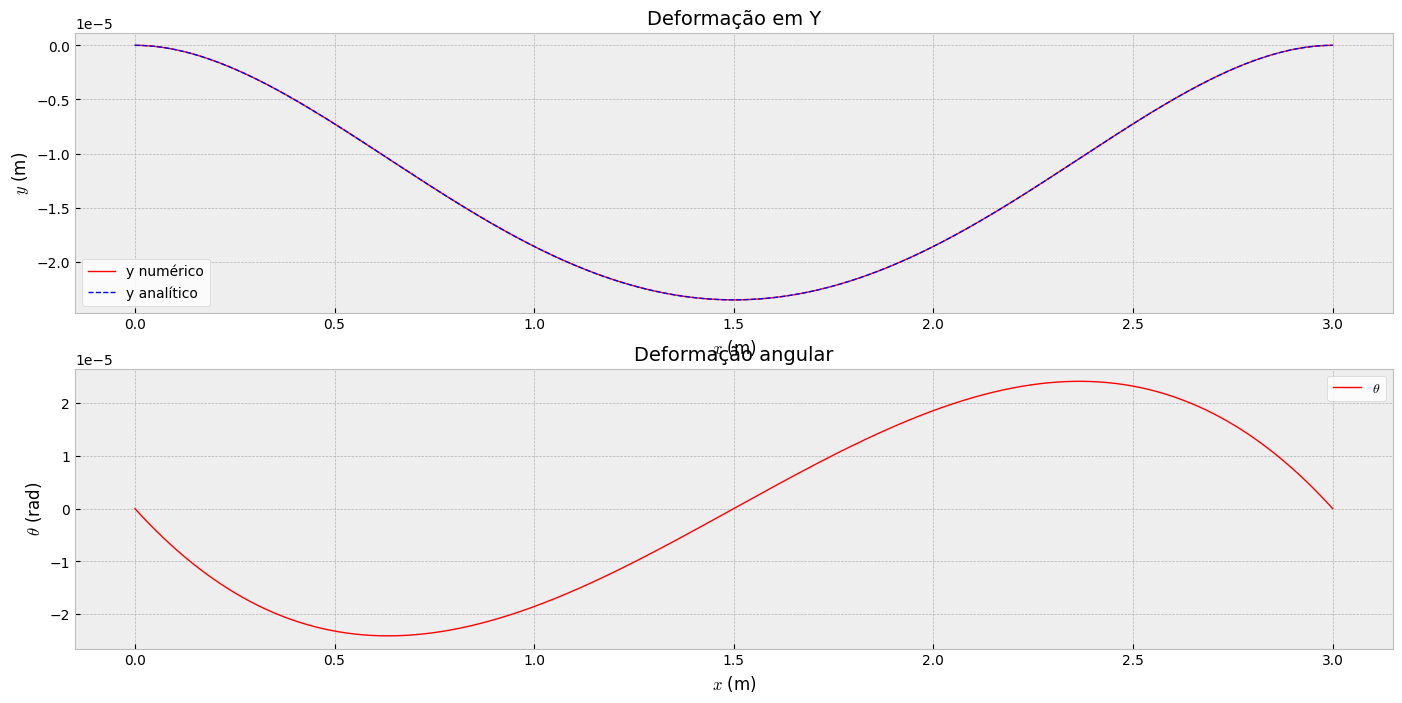

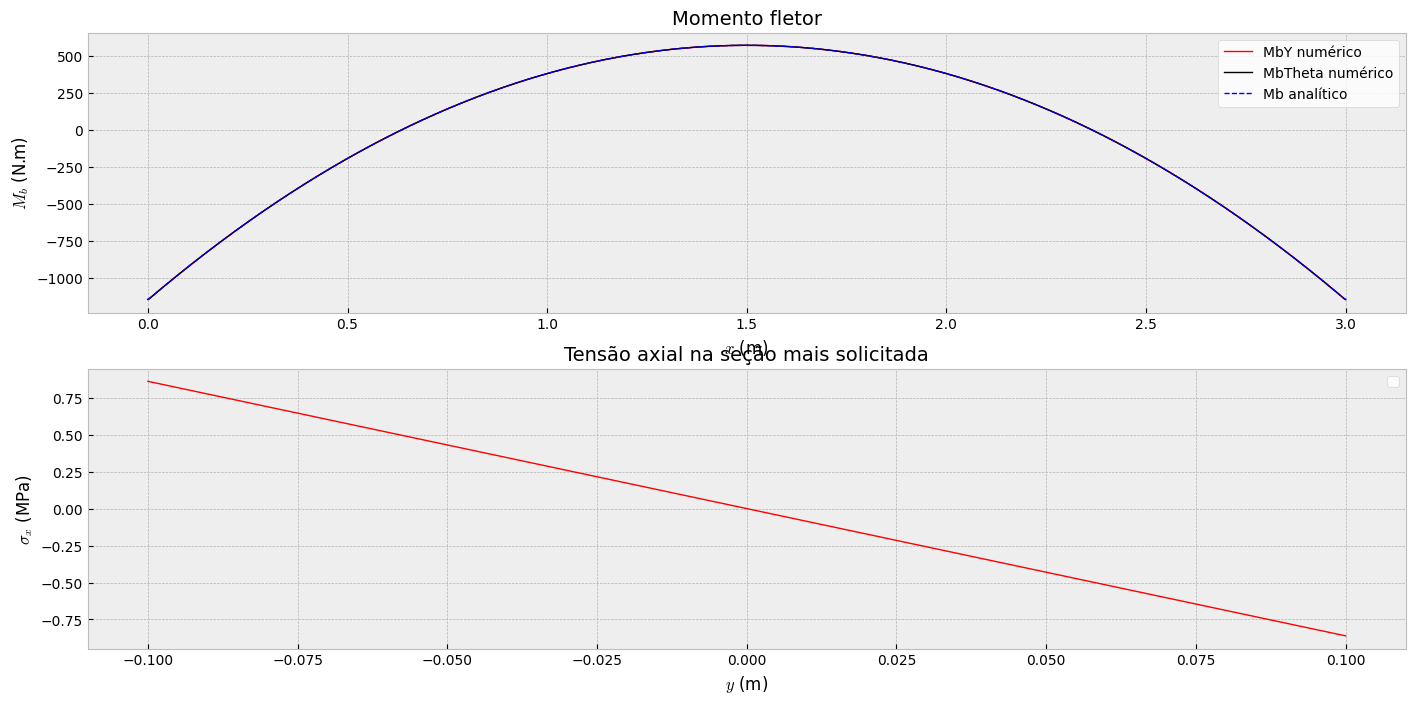

In [13]:
# parametros da simulacao

## malha
L = 3.0   # m
ne = 1000   #n elementos
nx = ne+1   #n nos
nGL = 2*nx

## tubulacao
#d = 0.180  # m
#t = 0.022   # m
#D = d + 2.0*t   # m
#A = np.pi*(D**2.0 - d**2.0)/4.0   # m^2
#I = np.pi*(D**4.0 - d**4.0)/64.0   # m^4
## viga de secao retangular
a = 0.10  # m
b = 0.20  # m
A = a*b   # m^2
I = 0.10*0.20**3/12.0
E = 206.0*10.0**9.0   # GPa
rho = 7800.0   # kg/m^3
rho_l = rho*A   # kg/m

# carga
def q(x):
    return -9.81*rho_l

# geracao de malha 1D
X = np.linspace(0.0,L,nx)
dbX = np.stack((X,X))
dbX = dbX.transpose()
dbX = dbX.flatten()

# CCs
## x
Lyo = 0.0
Lyf = L
Lto = 0.0
Ltf = L

## outputs
Yo = 0.0
Yf = 0.0
Thetao = 0.0
Thetaf = 0.0

IEN_GL = np.zeros( (ne,4),dtype='int' )
for e in range(0,ne):
  IEN_GL[e] = [2*e,2*e+1,2*e+2,2*e+3]

# lista de indices de condicao de contorno
# int() truncates float, so if you have 12.8, using int() you get 12

ccY = [2*int(Lyo*ne/L), 2*int(Lyf*ne/L) + 2]
ccTheta = [2*int(Lto*ne/L) + 1, 2*int(Ltf*ne/L) + 3]

if int(Lyf*ne/L) == ne:
  ccY = [2*int(Lyo*ne/L), 2*(int(Lyf*ne/L) - 1) + 2]

if int(Ltf*ne/L) == ne:
  ccTheta = [2*int(Lto*ne/L) + 1, 2*(int(Ltf*ne/L) - 1) + 3]

# vetor com valores das condicoes de contorno
Ycc = np.empty( (nGL),dtype='float' )

Ycc[ccY[0]] = Yo
Ycc[ccY[1]] = Yf

Thetacc = np.empty( (nGL),dtype='float' )

Thetacc[ccTheta[0]] = Thetao
Thetacc[ccTheta[1]] = Thetaf

# inicializacao das matrizes globais
K = np.zeros( (nGL,nGL),dtype='float' )
#Q = np.zeros( (nGL,nGL),dtype='float' )
Q = np.zeros( (nGL),dtype='float' )

# obtendo matrizes elementares
## funcoes de interpolacao
K11 = lambda x,X1,X2 : dBh11(x,X1,X2)*dBh11(x,X1,X2)
K12 = lambda x,X1,X2 : dBh11(x,X1,X2)*dBh12(x,X1,X2)
K13 = lambda x,X1,X2:  dBh11(x,X1,X2)*dBh13(x,X1,X2)
K14 = lambda x,X1,X2 : dBh11(x,X1,X2)*dBh14(x,X1,X2)
K21 = lambda x,X1,X2 : dBh12(x,X1,X2)*dBh11(x,X1,X2)
K22 = lambda x,X1,X2 : dBh12(x,X1,X2)*dBh12(x,X1,X2)
K23 = lambda x,X1,X2 : dBh12(x,X1,X2)*dBh13(x,X1,X2)
K24 = lambda x,X1,X2 : dBh12(x,X1,X2)*dBh14(x,X1,X2)
K31 = lambda x,X1,X2 : dBh13(x,X1,X2)*dBh11(x,X1,X2)
K32 = lambda x,X1,X2 : dBh13(x,X1,X2)*dBh12(x,X1,X2)
K33 = lambda x,X1,X2 : dBh13(x,X1,X2)*dBh13(x,X1,X2)
K34 = lambda x,X1,X2 : dBh13(x,X1,X2)*dBh14(x,X1,X2)
K41 = lambda x,X1,X2 : dBh14(x,X1,X2)*dBh11(x,X1,X2)
K42 = lambda x,X1,X2 : dBh14(x,X1,X2)*dBh12(x,X1,X2)
K43 = lambda x,X1,X2 : dBh14(x,X1,X2)*dBh13(x,X1,X2)
K44 = lambda x,X1,X2 : dBh14(x,X1,X2)*dBh14(x,X1,X2)

Q11 = lambda x,X1,X2 : q(x)*Nh11(x,X1,X2)
Q12 = lambda x,X1,X2 : q(x)*Nh12(x,X1,X2)
Q13 = lambda x,X1,X2 : q(x)*Nh13(x,X1,X2)
Q14 = lambda x,X1,X2 : q(x)*Nh14(x,X1,X2)

## Funcao de integracao a ser usada
def INTEGRACAO_1(f,e):
     v1,v2,v3,v4 = IEN_GL[e]
     return sp.integrate.quad(f,dbX[v1],dbX[v3],(dbX[v1],dbX[v3]))[0]

## Integrando
kelem = np.empty((4,4,ne))
#qelem = np.empty((4,4,ne))
qelem = np.empty((4,ne))

for e in range(0,ne):
    Ke = E*I*np.array([[INTEGRACAO_1(K11,e),INTEGRACAO_1(K12,e),INTEGRACAO_1(K13,e),INTEGRACAO_1(K14,e)],
                       [INTEGRACAO_1(K21,e),INTEGRACAO_1(K22,e),INTEGRACAO_1(K23,e),INTEGRACAO_1(K24,e)],
                       [INTEGRACAO_1(K31,e),INTEGRACAO_1(K32,e),INTEGRACAO_1(K33,e),INTEGRACAO_1(K34,e)],
                       [INTEGRACAO_1(K41,e),INTEGRACAO_1(K42,e),INTEGRACAO_1(K43,e),INTEGRACAO_1(K44,e)]])     

    #Qe = np.array([[INTEGRACAO_1(Q11,e),INTEGRACAO_1(Q12,e),INTEGRACAO_1(Q13,e),INTEGRACAO_1(Q14,e)],
                   #[INTEGRACAO_1(Q21,e),INTEGRACAO_1(Q22,e),INTEGRACAO_1(Q23,e),INTEGRACAO_1(Q24,e)],
                   #[INTEGRACAO_1(Q31,e),INTEGRACAO_1(Q32,e),INTEGRACAO_1(Q33,e),INTEGRACAO_1(Q34,e)],
                   #[INTEGRACAO_1(Q41,e),INTEGRACAO_1(Q42,e),INTEGRACAO_1(Q43,e),INTEGRACAO_1(Q44,e)]]) 

    Qe = np.array([INTEGRACAO_1(Q11,e),INTEGRACAO_1(Q12,e),INTEGRACAO_1(Q13,e),INTEGRACAO_1(Q14,e)])

    kelem[:,:,e] = Ke
    #qelem[:,:,e] = Qe
    qelem[:,e] = Qe

for e in range(0,ne):

 for ilocal in range(0,4):
  iglobal = IEN_GL[e,ilocal]
  for jlocal in range(0,4):
   jglobal = IEN_GL[e,jlocal]

   K[iglobal,jglobal] += kelem[ilocal,jlocal,e]
   #Q[iglobal,jglobal] += qelem[ilocal,jlocal,e]

for e in range(0,ne):
 for ilocal in range(0,4):
  Q[2*e + ilocal] += qelem[ilocal,e]

#print(np.array_str(K, precision=2, suppress_small=True))
#print(np.array_str(Q, precision=2, suppress_small=True))

# definicao do sistema linear
A = K
#B = Q@q(dbX)
B = Q

# imposicao das c.c.s de Dirichlet em A e b
for i in ccY:
  A[i,:] = 0.0   # zerar linha
  A[i,i] = 1.0   # incluir 1 na diagonal

  B[i] = Ycc[i]

for i in ccTheta:
  A[i,:] = 0.0   # zerar linha
  A[i,i] = 1.0   # incluir 1 na diagonal

  B[i] = Thetacc[i]

print(np.linalg.det(A))


# solucao
cscA = sp.sparse.csc_matrix(A)   # Matrix form that improves sparse.linalg.solve
SOL = sp.sparse.linalg.spsolve(cscA,B)
#SOL = np.linalg.solve(A,B)
SOL = SOL.reshape((int(nGL/2),2))

Y = SOL[:,0]
Theta = SOL[:,1]

# curvatura (por diferenças centradas de ordem 2)
d2Y = np.empty(len(Y))

ho = (X[1] - X[0])
d2Y[0] = (2*Y[1] - 2*Y[0])/ho**2

hf = (X[-1] - X[-2])
d2Y[-1] = (- 2*Y[-1] + 2*Y[-2])/hf**2

for i in range(1,len(Y)-1):
    h = (X[i] - X[i-1])
    d2Y[i] = (Y[i+1] - 2*Y[i] + Y[i-1])/h**2

# curvatura via theta (dtheta/dx) (por diferenças centradas de ordem 1 e diferenças atrasadas ou avançadas nos contornos)

dTheta = np.empty(len(Theta))

ho = (X[1] - X[0])
dTheta[0] = (Theta[1] - Theta[0])/ho

hf = (X[-1] - X[-2])
dTheta[-1] = (Theta[-1] - Theta[-2])/hf

for i in range(1,len(Theta)-1):
    h = (X[i] - X[i-1])
    dTheta[i] = (Theta[i+1] - Theta[i-1])/(2*h)

# momento fletor e momento fletor maximo
MbY = E*I*d2Y# em MPa
MbYmax = E*I*np.max(d2Y) # N.m

MbTheta = E*I*dTheta   # N.m
MbThetamax = E*I*np.max(dTheta)  # N.m
print(MbThetamax)
# tensão axial na secao mais solicitada
#Y_CrossSection = np.linspace(-D/2.0, D/2.0, nx)
Y_CrossSection = np.linspace(-b/2.0, b/2.0, nx)

sigmab = (- MbYmax*Y_CrossSection/I)*10.0**(-6.0)   # MPa

# solucao analitica #######################

def Mb_a(x,w,L):

  return -(w/12)*(6*L*x - 6*x**2 - L**2)   # N.m

def Y_a(x,w,L,E,I):

  return ((w*x**2)/(24*E*I))*(L - x)**2

# plotando ################################
plt.style.use('bmh')

fig1, ((ax1), (ax2)) = plt.subplots(2, sharey=False, sharex=False, figsize = (17,8))

ax1.plot(X,Y, color='red', linewidth=1.0, label=r'y numérico')
ax1.plot(X,Y_a(X,q(X),L,E,I), 'b--', linewidth=1.0, label=r'y analítico')
ax1.set_title('Deformação em Y',fontdict={'fontsize':14})
ax1.set_xlabel('$x$ (m)',fontdict={'fontsize':12})
ax1.set_ylabel('$y$ (m)',fontdict={'fontsize':12})
ax1.legend(loc='best',facecolor ='w')

ax2.plot(X,Theta, color='red', linewidth=1.0, label=r'$\theta$')
ax2.set_title('Deformação angular',fontdict={'fontsize':14})
ax2.set_xlabel('$x$ (m)',fontdict={'fontsize':12})
ax2.set_ylabel('$\\theta$ (rad)',fontdict={'fontsize':12})
ax2.legend(loc='best',facecolor ='w')


fig1, ((ax3), (ax4)) = plt.subplots(2, sharey=False, sharex=False, figsize = (17,8))

ax3.plot(X,MbY, color='red', linewidth=1.0, label=r'MbY numérico')
ax3.plot(X,MbTheta, 'k', linewidth=1.0, label=r'MbTheta numérico')
ax3.plot(X,Mb_a(X,q(X),L), 'b--', linewidth=1.0, label=r'Mb analítico')
ax3.set_title('Momento fletor',fontdict={'fontsize':14})
ax3.set_xlabel('$x$ (m)',fontdict={'fontsize':12})
ax3.set_ylabel('$M_b$ (N.m)',fontdict={'fontsize':12})
ax3.legend(loc='best',facecolor ='w')

ax4.plot(Y_CrossSection,sigmab, color='red', linewidth=1.0)
ax4.set_title('Tensão axial na seção mais solicitada',fontdict={'fontsize':14})
ax4.set_xlabel('$y$ (m)',fontdict={'fontsize':12})
ax4.set_ylabel('$\\sigma_x$ (MPa)',fontdict={'fontsize':12})
ax4.legend(loc='best',facecolor ='w')

plt.show()

### Viga pinada engastada sujeita a cortante (ERRADO)

**Está errado. Eu usei a mesma formulação variacional para esse caso, o que não é possível, pois condições de contorno não são de Dirichlet**

\begin{equation}
 \left\{ \begin{aligned}
         EI\frac{\partial^4 y}{\partial x^4} - q(x) = 0 \\
         y(0) = 0 \, , \;\; y(L) = 0 \\
         EI y''(0) = 0 \\
         EI y'''(L_c) = P \\
        \end{aligned} 
 \right.
\end{equation}

\begin{equation}
y(x) = \frac{q(x)}{24 EI} x^4 + c_1 \frac{x^3}{6} + c_2 \frac{x^2}{2} + c_3 x + c_4
\end{equation}

Usando as condições de contorno de deslocamento vertical, cortante e momento chega-se a solução $y(x)$:

\begin{equation}
c_1 =  \frac{-L_c q + P}{E I} \; , \;\;\; c_2 = 0 \; , \;\;\; c_3 = \frac{-L^3 q + 4L^2 L_c q - 4 P L^2}{24 E I} \; , \;\;\; c_4 = 0
\end{equation}

\begin{equation}
y(x) = \frac{q(x)}{24 EI} x^4 + \frac{-L_c q + P}{6 EI} x^3 + \frac{-L^3 q + 4L^2 L_c q - 4 P L^2}{24 EI} x
\end{equation}

O problema está sendo descrito em função dos graus de liberdade $y(x)$ e $\theta(x)$ ($\theta = y'(x)$) e tendo agora a solução $y(x)$, pode-se descrever as condições de contorno de cortante e momento em função do grau de liberdade $\theta(x)$:

\begin{equation}
\theta(0) = y'(0) = 0
\end{equation}

\begin{equation}
\theta (L_c) = y'(L_c) = ...
\end{equation}


Y boundary conditions' nodes: [0, 2000]
Theta boundary conditions' nodes: [1, 1003]


c:\Python3.10.11\lib\site-packages\numpy\linalg\linalg.py:2180: RuntimeWarning: overflow encountered in det
  r = _umath_linalg.det(a, signature=signature)


inf


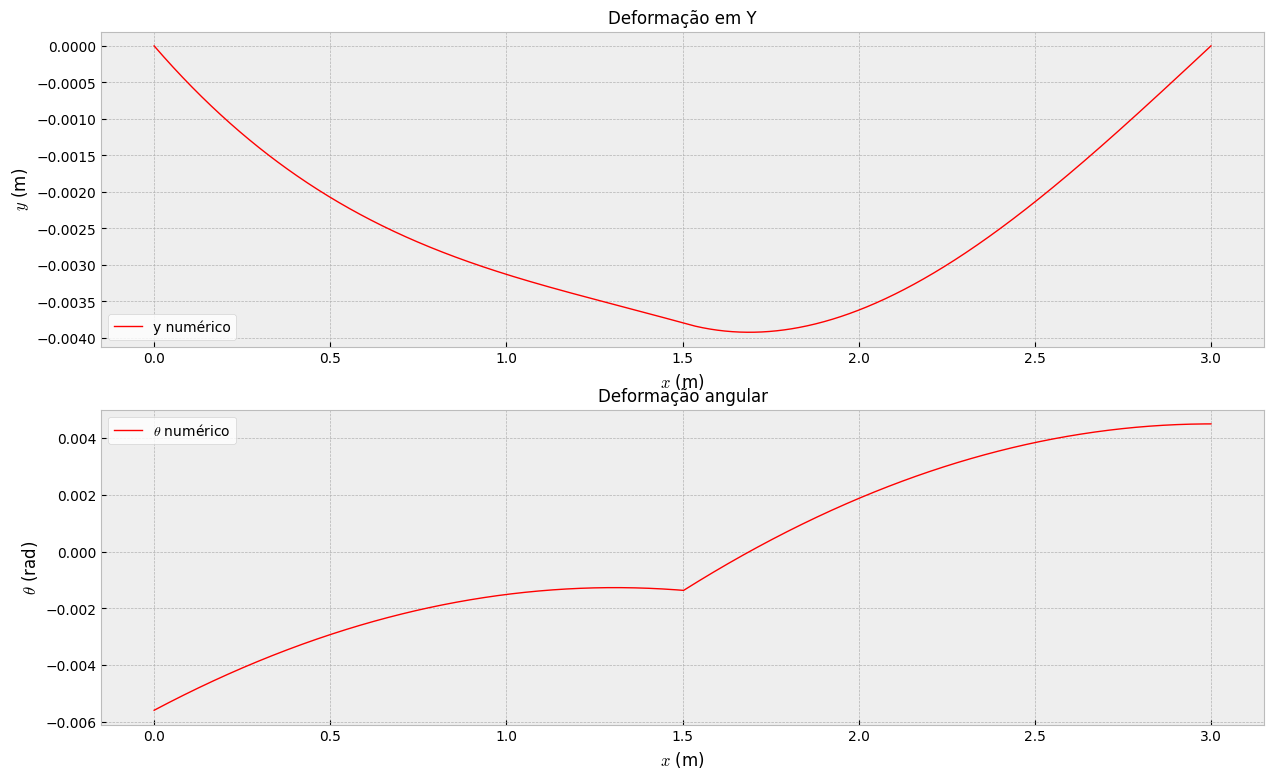

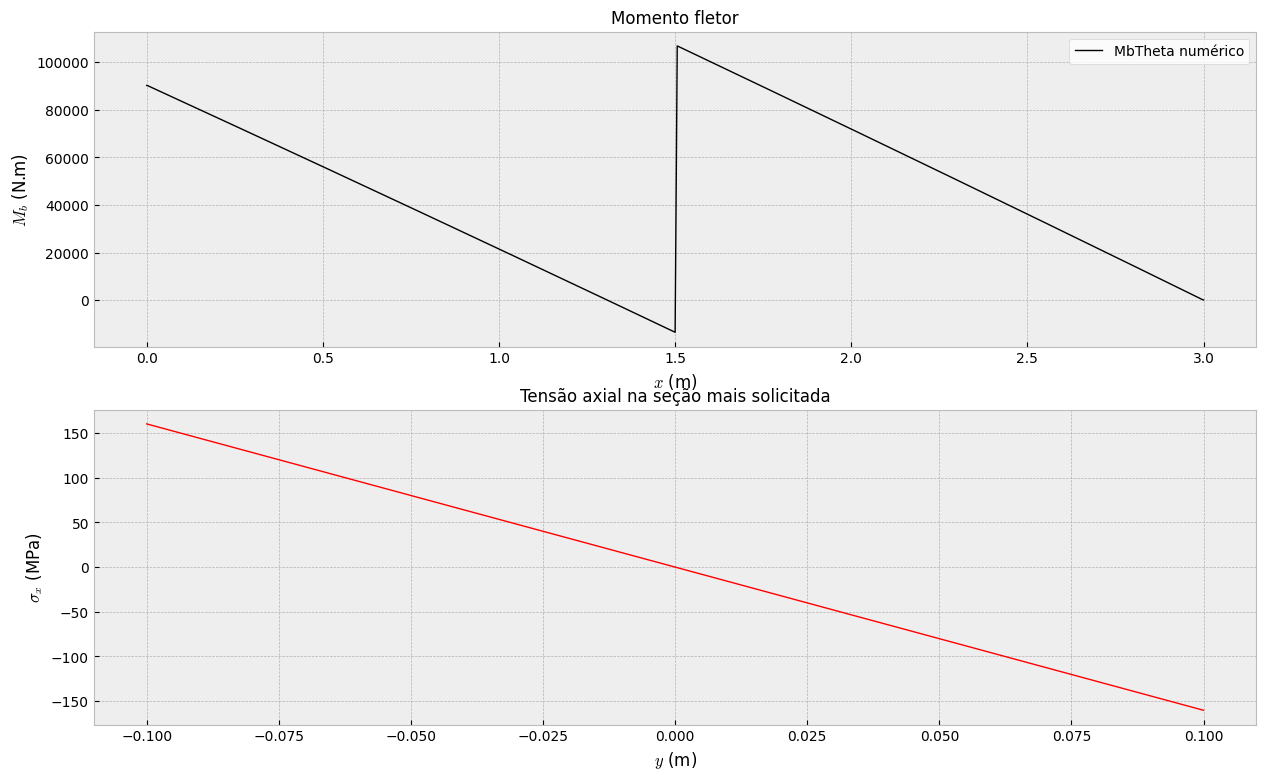

In [10]:
# parametros da simulacao

## malha
L = 3.0   # m
ne = 1000   #n elementos
nx = ne+1   #n nos
nGL = 2*nx

## tubulacao
#d = 0.180  # m
#t = 0.022   # m
#D = d + 2.0*t   # m
#A = np.pi*(D**2.0 - d**2.0)/4.0   # m^2
#I = np.pi*(D**4.0 - d**4.0)/64.0   # m^4
## viga de secao retangular
a = 0.10  # m
b = 0.20  # m
A = a*b   # m^2
I = 0.10*0.20**3/12.0
E = 206.0*10.0**9.0   # GPa
rho = 7800.0   # kg/m^3
rho_l = rho*A   # kg/m

# cargas
def q(x):
    return -9.81*rho_l

P = 50000.0   # N   # cortante em módulo (entra na condicao de contorno)

# geracao de malha 1D
X = np.linspace(0.0,L,nx)
dbX = np.stack((X,X))
dbX = dbX.transpose()
dbX = dbX.flatten()

# CCs 2
## x
Lc = 1.5   # onde cortante será aplicado
Lyo = 0.0
Lyf = L
Lto = 0.0
Ltf = Lc

## outputs
Yo = 0.0
Yf = 0.0
Thetao = ((-L**3.0 + 4.0*Lc*L**2.0)*q(X[0]) - 4.0*L**2.0*P)/(24.0*E*I)
Thetaf = ( (-L**3.0 + 4.0*Lc*L**2.0 - 8.0*Lc**3.0)*q(X[0]) + (12.0*Lc**2.0 - 4.0*L**2.0)*P )/(24.0*E*I)

IEN_GL = np.zeros( (ne,4),dtype='int' )
for e in range(0,ne):
  IEN_GL[e] = [2*e,2*e+1,2*e+2,2*e+3]

# lista de indices de condicao de contorno
# int() truncates float, so if you have 12.8, using int() you get 12

ccY = [2*int(Lyo*ne/L), 2*int(Lyf*ne/L) + 2]
ccTheta = [2*int(Lto*ne/L) + 1, 2*int(Ltf*ne/L) + 3]

if int(Lyf*ne/L) == ne:
  ccY = [2*int(Lyo*ne/L), 2*(int(Lyf*ne/L) - 1) + 2]

elif int(Ltf*ne/L) == ne:
  ccTheta = [2*int(Lto*ne/L) + 1, 2*(int(Ltf*ne/L) - 1) + 3]

print("Y boundary conditions' nodes: {}".format(ccY))
print("Theta boundary conditions' nodes: {}".format(ccTheta))

# vetor com valores das condicoes de contorno
Ycc = np.empty( (nGL),dtype='float' )

Ycc[ccY[0]] = Yo
Ycc[ccY[1]] = Yf

Thetacc = np.empty( (nGL),dtype='float' )

Thetacc[ccTheta[0]] = Thetao
Thetacc[ccTheta[1]] = Thetaf

# inicializacao das matrizes globais
K = np.zeros( (nGL,nGL),dtype='float' )
#Q = np.zeros( (nGL,nGL),dtype='float' )
Q = np.zeros( (nGL),dtype='float' )

# obtendo matrizes elementares
## funcoes de interpolacao
K11 = lambda x,X1,X2 : dBh11(x,X1,X2)*dBh11(x,X1,X2)
K12 = lambda x,X1,X2 : dBh11(x,X1,X2)*dBh12(x,X1,X2)
K13 = lambda x,X1,X2:  dBh11(x,X1,X2)*dBh13(x,X1,X2)
K14 = lambda x,X1,X2 : dBh11(x,X1,X2)*dBh14(x,X1,X2)
K21 = lambda x,X1,X2 : dBh12(x,X1,X2)*dBh11(x,X1,X2)
K22 = lambda x,X1,X2 : dBh12(x,X1,X2)*dBh12(x,X1,X2)
K23 = lambda x,X1,X2 : dBh12(x,X1,X2)*dBh13(x,X1,X2)
K24 = lambda x,X1,X2 : dBh12(x,X1,X2)*dBh14(x,X1,X2)
K31 = lambda x,X1,X2 : dBh13(x,X1,X2)*dBh11(x,X1,X2)
K32 = lambda x,X1,X2 : dBh13(x,X1,X2)*dBh12(x,X1,X2)
K33 = lambda x,X1,X2 : dBh13(x,X1,X2)*dBh13(x,X1,X2)
K34 = lambda x,X1,X2 : dBh13(x,X1,X2)*dBh14(x,X1,X2)
K41 = lambda x,X1,X2 : dBh14(x,X1,X2)*dBh11(x,X1,X2)
K42 = lambda x,X1,X2 : dBh14(x,X1,X2)*dBh12(x,X1,X2)
K43 = lambda x,X1,X2 : dBh14(x,X1,X2)*dBh13(x,X1,X2)
K44 = lambda x,X1,X2 : dBh14(x,X1,X2)*dBh14(x,X1,X2)

Q11 = lambda x,X1,X2 : q(x)*Nh11(x,X1,X2)
Q12 = lambda x,X1,X2 : q(x)*Nh12(x,X1,X2)
Q13 = lambda x,X1,X2 : q(x)*Nh13(x,X1,X2)
Q14 = lambda x,X1,X2 : q(x)*Nh14(x,X1,X2)

## Funcao de integracao a ser usada
def INTEGRACAO_1(f,e):
     v1,v2,v3,v4 = IEN_GL[e]
     return sp.integrate.quad(f,dbX[v1],dbX[v3],(dbX[v1],dbX[v3]))[0]

## Integrando
kelem = np.empty((4,4,ne))
#qelem = np.empty((4,4,ne))
qelem = np.empty((4,ne))

for e in range(0,ne):
    Ke = E*I*np.array([[INTEGRACAO_1(K11,e),INTEGRACAO_1(K12,e),INTEGRACAO_1(K13,e),INTEGRACAO_1(K14,e)],
                       [INTEGRACAO_1(K21,e),INTEGRACAO_1(K22,e),INTEGRACAO_1(K23,e),INTEGRACAO_1(K24,e)],
                       [INTEGRACAO_1(K31,e),INTEGRACAO_1(K32,e),INTEGRACAO_1(K33,e),INTEGRACAO_1(K34,e)],
                       [INTEGRACAO_1(K41,e),INTEGRACAO_1(K42,e),INTEGRACAO_1(K43,e),INTEGRACAO_1(K44,e)]])     

    #Qe = np.array([[INTEGRACAO_1(Q11,e),INTEGRACAO_1(Q12,e),INTEGRACAO_1(Q13,e),INTEGRACAO_1(Q14,e)],
                   #[INTEGRACAO_1(Q21,e),INTEGRACAO_1(Q22,e),INTEGRACAO_1(Q23,e),INTEGRACAO_1(Q24,e)],
                   #[INTEGRACAO_1(Q31,e),INTEGRACAO_1(Q32,e),INTEGRACAO_1(Q33,e),INTEGRACAO_1(Q34,e)],
                   #[INTEGRACAO_1(Q41,e),INTEGRACAO_1(Q42,e),INTEGRACAO_1(Q43,e),INTEGRACAO_1(Q44,e)]]) 

    Qe = np.array([INTEGRACAO_1(Q11,e),INTEGRACAO_1(Q12,e),INTEGRACAO_1(Q13,e),INTEGRACAO_1(Q14,e)])

    kelem[:,:,e] = Ke
    #qelem[:,:,e] = Qe
    qelem[:,e] = Qe

for e in range(0,ne):

 for ilocal in range(0,4):
  iglobal = IEN_GL[e,ilocal]
  for jlocal in range(0,4):
   jglobal = IEN_GL[e,jlocal]

   K[iglobal,jglobal] += kelem[ilocal,jlocal,e]
   #Q[iglobal,jglobal] += qelem[ilocal,jlocal,e]

for e in range(0,ne):
 for ilocal in range(0,4):
  Q[2*e + ilocal] += qelem[ilocal,e]

#print(np.array_str(K, precision=2, suppress_small=True))
#print(np.array_str(Q, precision=2, suppress_small=True))

# definicao do sistema linear
A = K
#B = Q@q(dbX)
B = Q

# imposicao das c.c.s de Dirichlet em A e b
for i in ccY:
  A[i,:] = 0.0   # zerar linha
  A[i,i] = 1.0   # incluir 1 na diagonal

  B[i] = Ycc[i]

for i in ccTheta:
  A[i,:] = 0.0   # zerar linha
  A[i,i] = 1.0   # incluir 1 na diagonal

  B[i] = Thetacc[i]

print(np.linalg.det(A))


# solucao
cscA = sp.sparse.csc_matrix(A)   # Matrix form that improves sparse.linalg.solve
SOL = sp.sparse.linalg.spsolve(cscA,B)
#SOL = np.linalg.solve(A,B)
SOL = SOL.reshape((int(nGL/2),2))

Y = SOL[:,0]
Theta = SOL[:,1]

# curvatura (por diferenças centradas de ordem 2)
d2Y = np.empty(len(Y))

ho = (X[1] - X[0])
d2Y[0] = (2*Y[1] - 2*Y[0])/ho**2

hf = (X[-1] - X[-2])
d2Y[-1] = (- 2*Y[-1] + 2*Y[-2])/hf**2

for i in range(1,len(Y)-1):
    h = (X[i] - X[i-1])
    d2Y[i] = (Y[i+1] - 2*Y[i] + Y[i-1])/h**2

# curvatura via theta (dtheta/dx) (por diferenças centradas de ordem 1 e diferenças atrasadas ou avançadas nos contornos)

dTheta = np.empty(len(Theta))

ho = (X[1] - X[0])
dTheta[0] = (Theta[1] - Theta[0])/ho

hf = (X[-1] - X[-2])
dTheta[-1] = (Theta[-1] - Theta[-2])/hf

for i in range(1,len(Theta)-1):
    h = (X[i] - X[i-1])
    dTheta[i] = (Theta[i+1] - Theta[i-1])/(2*h)

# momento fletor e momento fletor maximo
MbY = E*I*d2Y# em MPa
MbYmax = E*I*np.max(d2Y) # N.m

MbTheta = E*I*dTheta   # N.m
MbThetamax = E*I*np.max(dTheta)  # N.m

# tensão axial na secao mais solicitada
#Y_CrossSection = np.linspace(-D/2.0, D/2.0, nx)
Y_CrossSection = np.linspace(-b/2.0, b/2.0, 100)

sigmab = (- MbThetamax*Y_CrossSection/I)*10.0**(-6.0)   # MPa

# plotando ################################
plt.style.use('bmh')

fig1, ((ax1), (ax2)) = plt.subplots(2, sharey=False, sharex=False, figsize = (15,9))

ax1.plot(X,Y, color='red', linewidth=1.0, label=r'y numérico')
ax1.set_title('Deformação em Y',fontdict={'fontsize':12})
ax1.set_xlabel('$x$ (m)',fontdict={'fontsize':12})
ax1.set_ylabel('$y$ (m)',fontdict={'fontsize':12})
ax1.legend(loc='best',facecolor ='w')

ax2.plot(X,Theta, color='red', linewidth=1.0, label=r'$\theta$ numérico')
ax2.set_title('Deformação angular',fontdict={'fontsize':12})
ax2.set_xlabel('$x$ (m)',fontdict={'fontsize':12})
ax2.set_ylabel('$\\theta$ (rad)',fontdict={'fontsize':12})
ax2.legend(loc='best',facecolor ='w')


fig1, ((ax3), (ax4)) = plt.subplots(2, sharey=False, sharex=False, figsize = (15,9))

#ax3.plot(X,MbY, color='red', linewidth=1.0, label=r'MbY numérico')
ax3.plot(X,MbTheta, 'k', linewidth=1.0, label=r'MbTheta numérico')
ax3.set_title('Momento fletor',fontdict={'fontsize':12})
ax3.set_xlabel('$x$ (m)',fontdict={'fontsize':12})
ax3.set_ylabel('$M_b$ (N.m)',fontdict={'fontsize':12})
ax3.legend(loc='best',facecolor ='w')

ax4.plot(Y_CrossSection,sigmab, color='red', linewidth=1.0, label=r'$\sigma_b$ numérico')
ax4.set_title('Tensão axial na seção mais solicitada',fontdict={'fontsize':12})
ax4.set_xlabel('$y$ (m)',fontdict={'fontsize':12})
ax4.set_ylabel('$\\sigma_x$ (MPa)',fontdict={'fontsize':12})

plt.show()

## Viga sujeita a carga axial e distribuida

$$ EI\frac{\partial^4 y}{\partial x^4} + P\frac{\partial^2 y}{\partial x^2} - \mu_{bo}^L q(x) = 0 $$


$$ \int_\Omega \left [ EI\frac{\partial^4 y}{\partial x^4} + P\frac{\partial^2 y}{\partial x^2} - \mu_{bo}^L q(x) \right ] \cdot \omega(x) \; d\Omega = 0 $$

Aplicando Toerema de Green para enfraquecer a equação:

$$ -\int_{\Omega} EI\frac{\partial^3 y}{\partial x^3} \frac{\partial \omega(x)}{\partial x} \; d\Omega + \int_{\Gamma} EI\frac{\partial^3 y}{\partial x^3} \omega(x) \; d\Gamma - \int_{\Omega} P\frac{\partial y}{\partial x} \frac{\partial \omega(x)}{\partial x} \; d\Omega + \int_{\Gamma} P\frac{\partial y}{\partial x} \omega(x) \; d\Gamma - \int_{\Omega} \mu_{bo}^L q(x) \omega(x) \; d\Omega = 0 $$

Assumindo C.C.'s de Dirichlet:

$$ -\int_{\Omega} EI\frac{\partial^3 y}{\partial x^3} \frac{\partial \omega(x)}{\partial x} \; d\Omega - \int_{\Omega} P\frac{\partial y}{\partial x} \frac{\partial \omega(x)}{\partial x} \; d\Omega - \int_{\Omega} \mu_{bo}^L q(x) \omega(x) \; d\Omega = 0 $$

Repetindo o procedimento para as terceiras derivadas:

$$ \int_{\Omega} EI\frac{\partial^2 y}{\partial x^2} \frac{\partial^2 \omega(x)}{\partial x^2} \; d\Omega - \int_{\Gamma} EI\frac{\partial^2 y}{\partial x^2} \frac{\partial \omega(x)}{\partial x} \; d\Gamma - \int_{\Omega} P\frac{\partial y}{\partial x} \frac{\partial \omega(x)}{\partial x} \; d\Omega - \int_{\Omega} \mu_{bo}^L q(x) \omega(x) \; d\Omega = 0 $$

$$ \int_{\Omega} EI\frac{\partial^2 y}{\partial x^2} \frac{\partial^2 \omega(x)}{\partial x^2} \; d\Omega - \int_{\Omega} P\frac{\partial y}{\partial x} \frac{\partial \omega(x)}{\partial x} \; d\Omega - \int_{\Omega} \mu_{bo}^L q(x) \omega(x) \; d\Omega = 0 $$

Agora será realizada discretização da formulação fraca. O elemento a ser utilizado é composto por 2 nós e apresentará 4 graus de liberdade, um deslocamento vertical e um angular para cada nó. Isso é necessário por conta da ordem da EDO com que estamos lidando, uma EDO de quarta ordem. Essa EDO precisa de pelo menos 4 condições de contorno:

$$ \sum_{i}^{\infty} \sum_{j}^{\infty} \int_{\Omega} EI\frac{\partial^2 (N_i y_i)}{\partial x^2} \frac{\partial^2 (N_j \omega_j)}{\partial x^2} \; d\Omega - \sum_{i}^{\infty} \sum_{j}^{\infty} \int_{\Omega} P\frac{\partial (N_i y_i)}{\partial x} \frac{\partial (N_j \omega_j)}{\partial x} \; d\Omega - \sum_{i}^{\infty} \sum_{j}^{\infty} \int_{\Omega} N_k q_k \cdot N_j \omega_j \; d\Omega = 0 $$

$$ \sum_{i}^{\infty} \sum_{j}^{\infty} EI \int_{\Omega} B'_i B'_j \; d\Omega \cdot y_i \omega_j - \sum_{i}^{\infty} \sum_{j}^{\infty} P \int_{\Omega} B_i B_j \; d\Omega \cdot y_i \omega_j - \sum_{i}^{\infty} \sum_{j}^{\infty} \int_{\Omega} N_k N_j \; d\Omega \cdot q_k \omega_j = 0 $$

Dividindo a equação por $\omega_j$ e substituindo os somatórios duplos por somatórios de elemento, a equação assume a seguinte forma: 

$$ \sum_{e}^{\infty} EI \int_{\Omega} B'_i B'_j \; d\Omega \cdot y_i - \sum_{e}^{\infty} P \int_{\Omega} B_i B_j \; d\Omega \cdot y_i - \sum_{e}^{\infty} \int_{\Omega} N_k N_j \; d\Omega \cdot q_k = 0 $$

As integrais das funções de interpolação correspondem a matrizes elementares de rigidez e carga:

$$ K^e = EI \int_{\Omega} B'_i B'_j \; d\Omega \;\;,\;\;\;\; G^e = P \int_{\Omega} B_i B_j \; d\Omega \;\;,\;\;\;\; Q^e = \int_{\Omega} N_i N_j \; d\Omega $$

Fazendo a montagem das matrizes globais $K$ e $Q$:

$$ K \cdot y_i - G \cdot y_i - Q \cdot q_k = 0 $$

Carga axial: 1057479.2454615668


c:\Python3.9.5\lib\site-packages\numpy\linalg\linalg.py:2154: RuntimeWarning: overflow encountered in det
  r = _umath_linalg.det(a, signature=signature)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


-inf


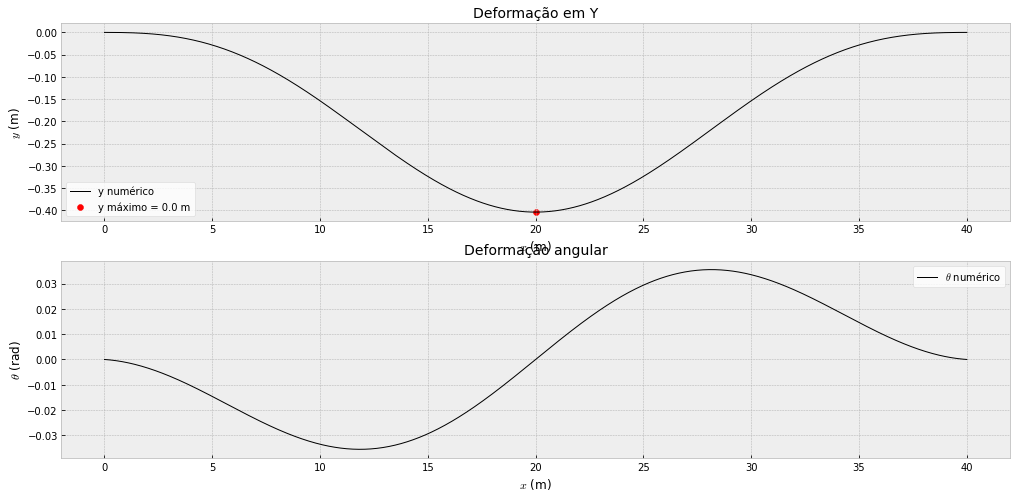

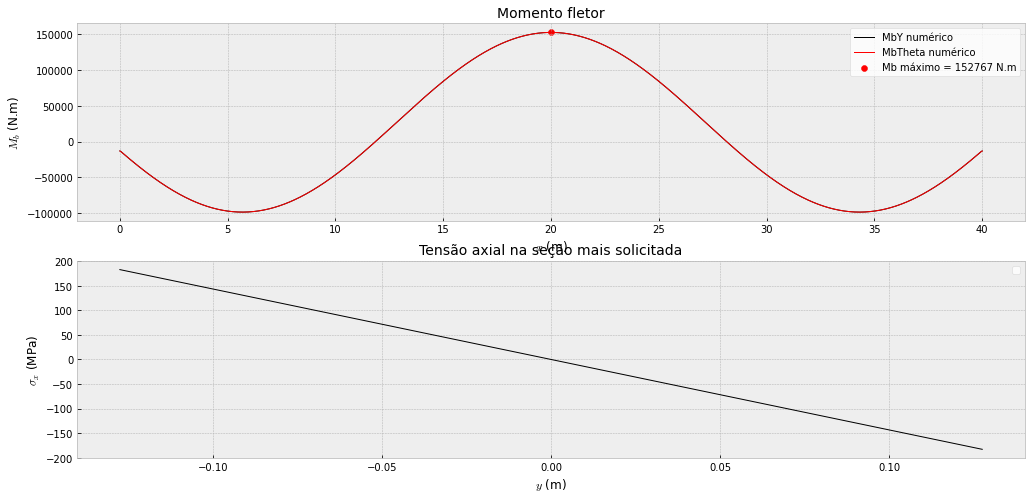

In [13]:
# parametros da simulacao

## malha
L = 40.0   # m
ne = 1000   #n elementos
nx = ne+1   #n nos
nGL = 2*nx

## tubulacao
#d = 0.180  # m
#t = 0.022   # m
#D = d + 2.0*t   # m
#A = np.pi*(D**2.0 - d**2.0)/4.0   # m^2
#I = np.pi*(D**4.0 - d**4.0)/64.0   # m^4
#E = 206.0*10.0**9.0   # GPa
#rho = 7800.0   # kg/m^3
#rho_l = rho*A   # kg/m
## viga de secao retangular
#a = 0.10  # m
#b = 0.20  # m
#A = a*b   # m^2
#I = 0.10*0.20**3/12.0
#E = 206.0*10.0**9.0   # GPa
#rho = 7800.0   # kg/m^3
#rho_l = rho*A   # kg/m
## RC2-U Prod Mero 2, 180 ALO, flooded, Case 19 - RLT UE, PSI UE/UE
OD = 0.255   #m
t = 0.021   #m   
ID = OD - 2.0*t   #m
A = np.pi*(OD**2.0 - ID**2.0)/4.0   #m^2
I = np.pi*(OD**4.0 - ID**4.0)/64.0   #m^4
E = 206.0*10.0**9.0   #Pa
EI = E*I

coat_ID = OD
coat_t = 0.042
coat_OD = coat_ID + 2*coat_t   #m

liner_OD = ID
liner_t = 0.0037
liner_ID = liner_OD - 2*liner_t   #m

steel_density = 7850.0   #kg/m^3
coat_density = 707.2   #kg/m^3
liner_density = 8440.0   #kg/m^3
seawater_density = 1038.0   #kg/m^3
embedmentContentDensity_1 = 1038.0    #kg/m^3

steel_weight = A*steel_density                     # Flowline linear weight [kg/m]
coat_weight = (np.pi*(coat_OD**2.0 - coat_ID**2.0)/4.0)*coat_density             # Coating linear weight [kg/m]
liner_weight = (np.pi*(liner_OD**2.0 - liner_ID**2.0)/4.0)*liner_density         # Liner linear weight [kg/m]
pipe_buoyancy_weight = -np.pi*(coat_OD**2.0/4.0)*seawater_density                # Buoyancy of the pipe [kg/m]

pipe_weight_wo_content = steel_weight + liner_weight + coat_weight + pipe_buoyancy_weight    # Total linear weight [kg/m]
cont_weight_1 = np.pi*((liner_ID**2.0)/4.0)*embedmentContentDensity_1          # Content linear weight used for embedment - Contact #1 [kg/m]

gravity = -9.81 #m/s^2

q = (pipe_weight_wo_content + cont_weight_1)*gravity   #N/m

## lateral friction coefficient
mu_res = 1.21

# cargas
def f(x):
    return mu_res*abs(q)   # N

#c = 4*np.pi
#P = -c*E*I/L**2   # N

RLT = 156.96e3   # N
DP = 60*1e6   # Pa
Ai = np.pi*(ID**2.0)/4.0   # m^2
nu = 0.303   # Poisson
As = A   # m^2
alpha = 1.17e-5   # °C^(-1)
DT = 10   # °C
P = abs(RLT - DP*Ai*(1-2*nu) - As*alpha*DT*E)   # Effective Axial Force

print('Carga axial: {}'.format(P))

# geracao de malha 1D
X = np.linspace(0.0,L,nx)
dbX = np.stack((X,X))
dbX = dbX.transpose()
dbX = dbX.flatten()

# CCs
## x
Lyo = 0.0
Lyf = L
Lto = 0.0
Ltf = L

## outputs
Yo = 0.0
Yf = 0.0
Thetao = 0.0
Thetaf = 0.0

IEN_GL = np.zeros( (ne,4),dtype='int' )
for e in range(0,ne):
  IEN_GL[e] = [2*e,2*e+1,2*e+2,2*e+3]

# lista de indices de condicao de contorno
# int() truncates float, so if you have 12.8, using int() you get 12

ccY = [2*int(Lyo*ne/L), 2*int(Lyf*ne/L) + 2]
ccTheta = [2*int(Lto*ne/L) + 1, 2*int(Ltf*ne/L) + 3]

if int(Lyf*ne/L) == ne:
  ccY = [2*int(Lyo*ne/L), 2*(int(Lyf*ne/L) - 1) + 2]

if int(Ltf*ne/L) == ne:
  ccTheta = [2*int(Lto*ne/L) + 1, 2*(int(Ltf*ne/L) - 1) + 3]

# vetor com valores das condicoes de contorno
Ycc = np.empty( (nGL),dtype='float' )

Ycc[ccY[0]] = Yo
Ycc[ccY[1]] = Yf

Thetacc = np.empty( (nGL),dtype='float' )

Thetacc[ccTheta[0]] = Thetao
Thetacc[ccTheta[1]] = Thetaf

# inicializacao das matrizes globais
K = np.zeros( (nGL,nGL),dtype='float' )
G = np.zeros( (nGL,nGL),dtype='float' )
#Q = np.zeros( (nGL,nGL),dtype='float' )
Q = np.zeros( (nGL),dtype='float' )

# obtendo matrizes elementares
## funcoes de interpolacao
K11 = lambda x,X1,X2 : dBh11(x,X1,X2)*dBh11(x,X1,X2)
K12 = lambda x,X1,X2 : dBh11(x,X1,X2)*dBh12(x,X1,X2)
K13 = lambda x,X1,X2:  dBh11(x,X1,X2)*dBh13(x,X1,X2)
K14 = lambda x,X1,X2 : dBh11(x,X1,X2)*dBh14(x,X1,X2)
K21 = lambda x,X1,X2 : dBh12(x,X1,X2)*dBh11(x,X1,X2)
K22 = lambda x,X1,X2 : dBh12(x,X1,X2)*dBh12(x,X1,X2)
K23 = lambda x,X1,X2 : dBh12(x,X1,X2)*dBh13(x,X1,X2)
K24 = lambda x,X1,X2 : dBh12(x,X1,X2)*dBh14(x,X1,X2)
K31 = lambda x,X1,X2 : dBh13(x,X1,X2)*dBh11(x,X1,X2)
K32 = lambda x,X1,X2 : dBh13(x,X1,X2)*dBh12(x,X1,X2)
K33 = lambda x,X1,X2 : dBh13(x,X1,X2)*dBh13(x,X1,X2)
K34 = lambda x,X1,X2 : dBh13(x,X1,X2)*dBh14(x,X1,X2)
K41 = lambda x,X1,X2 : dBh14(x,X1,X2)*dBh11(x,X1,X2)
K42 = lambda x,X1,X2 : dBh14(x,X1,X2)*dBh12(x,X1,X2)
K43 = lambda x,X1,X2 : dBh14(x,X1,X2)*dBh13(x,X1,X2)
K44 = lambda x,X1,X2 : dBh14(x,X1,X2)*dBh14(x,X1,X2)

G11 = lambda x,X1,X2 : Bh11(x,X1,X2)*Bh11(x,X1,X2)
G12 = lambda x,X1,X2 : Bh11(x,X1,X2)*Bh12(x,X1,X2)
G13 = lambda x,X1,X2:  Bh11(x,X1,X2)*Bh13(x,X1,X2)
G14 = lambda x,X1,X2 : Bh11(x,X1,X2)*Bh14(x,X1,X2)
G21 = lambda x,X1,X2 : Bh12(x,X1,X2)*Bh11(x,X1,X2)
G22 = lambda x,X1,X2 : Bh12(x,X1,X2)*Bh12(x,X1,X2)
G23 = lambda x,X1,X2 : Bh12(x,X1,X2)*Bh13(x,X1,X2)
G24 = lambda x,X1,X2 : Bh12(x,X1,X2)*Bh14(x,X1,X2)
G31 = lambda x,X1,X2 : Bh13(x,X1,X2)*Bh11(x,X1,X2)
G32 = lambda x,X1,X2 : Bh13(x,X1,X2)*Bh12(x,X1,X2)
G33 = lambda x,X1,X2 : Bh13(x,X1,X2)*Bh13(x,X1,X2)
G34 = lambda x,X1,X2 : Bh13(x,X1,X2)*Bh14(x,X1,X2)
G41 = lambda x,X1,X2 : Bh14(x,X1,X2)*Bh11(x,X1,X2)
G42 = lambda x,X1,X2 : Bh14(x,X1,X2)*Bh12(x,X1,X2)
G43 = lambda x,X1,X2 : Bh14(x,X1,X2)*Bh13(x,X1,X2)
G44 = lambda x,X1,X2 : Bh14(x,X1,X2)*Bh14(x,X1,X2)

Q11 = lambda x,X1,X2 : f(x)*Nh11(x,X1,X2)
Q12 = lambda x,X1,X2 : f(x)*Nh12(x,X1,X2)
Q13 = lambda x,X1,X2 : f(x)*Nh13(x,X1,X2)
Q14 = lambda x,X1,X2 : f(x)*Nh14(x,X1,X2)

## Funcao de integracao a ser usada
def INTEGRACAO_1(f,e):
     v1,v2,v3,v4 = IEN_GL[e]
     return sp.integrate.quad(f,dbX[v1],dbX[v3],(dbX[v1],dbX[v3]))[0]

## Integrando
kelem = np.empty((4,4,ne))
gelem = np.empty((4,4,ne))
#qelem = np.empty((4,4,ne))
qelem = np.empty((4,ne))

for e in range(0,ne):
    Ke = E*I*np.array([[INTEGRACAO_1(K11,e),INTEGRACAO_1(K12,e),INTEGRACAO_1(K13,e),INTEGRACAO_1(K14,e)],
                       [INTEGRACAO_1(K21,e),INTEGRACAO_1(K22,e),INTEGRACAO_1(K23,e),INTEGRACAO_1(K24,e)],
                       [INTEGRACAO_1(K31,e),INTEGRACAO_1(K32,e),INTEGRACAO_1(K33,e),INTEGRACAO_1(K34,e)],
                       [INTEGRACAO_1(K41,e),INTEGRACAO_1(K42,e),INTEGRACAO_1(K43,e),INTEGRACAO_1(K44,e)]])     

    Ge = P*np.array([[INTEGRACAO_1(G11,e),INTEGRACAO_1(G12,e),INTEGRACAO_1(G13,e),INTEGRACAO_1(G14,e)],
                       [INTEGRACAO_1(G21,e),INTEGRACAO_1(G22,e),INTEGRACAO_1(G23,e),INTEGRACAO_1(G24,e)],
                       [INTEGRACAO_1(G31,e),INTEGRACAO_1(G32,e),INTEGRACAO_1(G33,e),INTEGRACAO_1(G34,e)],
                       [INTEGRACAO_1(G41,e),INTEGRACAO_1(G42,e),INTEGRACAO_1(G43,e),INTEGRACAO_1(G44,e)]])

    #Qe = np.array([[INTEGRACAO_1(Q11,e),INTEGRACAO_1(Q12,e),INTEGRACAO_1(Q13,e),INTEGRACAO_1(Q14,e)],
                   #[INTEGRACAO_1(Q21,e),INTEGRACAO_1(Q22,e),INTEGRACAO_1(Q23,e),INTEGRACAO_1(Q24,e)],
                   #[INTEGRACAO_1(Q31,e),INTEGRACAO_1(Q32,e),INTEGRACAO_1(Q33,e),INTEGRACAO_1(Q34,e)],
                   #[INTEGRACAO_1(Q41,e),INTEGRACAO_1(Q42,e),INTEGRACAO_1(Q43,e),INTEGRACAO_1(Q44,e)]]) 

    Qe = np.array([INTEGRACAO_1(Q11,e),INTEGRACAO_1(Q12,e),INTEGRACAO_1(Q13,e),INTEGRACAO_1(Q14,e)])

    kelem[:,:,e] = Ke
    gelem[:,:,e] = Ge
    #qelem[:,:,e] = Qe
    qelem[:,e] = Qe

for e in range(0,ne):

 for ilocal in range(0,4):
  iglobal = IEN_GL[e,ilocal]
  for jlocal in range(0,4):
   jglobal = IEN_GL[e,jlocal]

   K[iglobal,jglobal] += kelem[ilocal,jlocal,e]
   G[iglobal,jglobal] += gelem[ilocal,jlocal,e]
   #Q[iglobal,jglobal] += qelem[ilocal,jlocal,e]

for e in range(0,ne):
 for ilocal in range(0,4):
  Q[2*e + ilocal] += qelem[ilocal,e]

#print(np.array_str(K, precision=2, suppress_small=True))
#print(np.array_str(Q, precision=2, suppress_small=True))

# definicao do sistema linear
A = K - G
#B = Q@q(dbX)
B = Q

# imposicao das c.c.s de Dirichlet em A e b
for i in ccY:
  A[i,:] = 0.0   # zerar linha
  A[i,i] = 1.0   # incluir 1 na diagonal

  B[i] = Ycc[i]

for i in ccTheta:
  A[i,:] = 0.0   # zerar linha
  A[i,i] = 1.0   # incluir 1 na diagonal

  B[i] = Thetacc[i]

print(np.linalg.det(A))


# solucao
cscA = sp.sparse.csc_matrix(A)   # Matrix form that improves sparse.linalg.solve
SOL = sp.sparse.linalg.spsolve(cscA,B)
#SOL = np.linalg.solve(A,B)
SOL = SOL.reshape((int(nGL/2),2))

Y = SOL[:,0]
Theta = SOL[:,1]

index_Ymax = np.where(abs(Y) == np.max(abs(Y)))   # for plotting max Y
index_Ymax = index_Ymax[0][0]

# curvatura (por diferenças centradas de ordem 2)
d2Y = np.empty(len(Y))

ho = (X[1] - X[0])
d2Y[0] = (2*Y[1] - 2*Y[0])/ho**2

hf = (X[-1] - X[-2])
d2Y[-1] = (- 2*Y[-1] + 2*Y[-2])/hf**2

for i in range(1,len(Y)-1):
    h = (X[i] - X[i-1])
    d2Y[i] = (Y[i+1] - 2*Y[i] + Y[i-1])/h**2

# curvatura via theta (dtheta/dx) (por diferenças centradas de ordem 1 e diferenças atrasadas ou avançadas nos contornos)

dTheta = np.empty(len(Theta))

ho = (X[1] - X[0])
dTheta[0] = (Theta[1] - Theta[0])/ho

hf = (X[-1] - X[-2])
dTheta[-1] = (Theta[-1] - Theta[-2])/hf

for i in range(1,len(Theta)-1):
    h = (X[i] - X[i-1])
    dTheta[i] = (Theta[i+1] - Theta[i-1])/(2*h)

# momento fletor e momento fletor maximo
MbY = E*I*d2Y# em MPa

index_MbYmax = np.where(abs(MbY) == np.max(abs(MbY)))   # for plotting max MbY
index_MbYmax = index_MbYmax[0][0]
MbYmax = MbY[index_MbYmax]

MbTheta = E*I*dTheta   # N.m
MbThetamax = np.max(abs(MbTheta))  # N.m

index_MbThetamax = np.where(abs(MbTheta) == np.max(abs(MbTheta)))   # for plotting max MbTheta
index_MbThetamax = index_MbThetamax[0][0]
MbThetamax = MbTheta[index_MbThetamax]

# tensão axial na secao mais solicitada
Y_CrossSection = np.linspace(-OD/2.0, OD/2.0, nx)
#Y_CrossSection = np.linspace(-b/2.0, b/2.0, nx)

sigmab = (- MbYmax*Y_CrossSection/I)*10.0**(-6.0)   # MPa

# plotando ################################
plt.style.use('bmh')

fig1, ((ax1), (ax2)) = plt.subplots(2, sharey=False, sharex=False, figsize = (17,8))

ax1.plot(X,Y, color='k', linewidth=1.0, label=r'y numérico')
ax1.scatter(X[index_Ymax], Y[index_Ymax], color='red', label=r'y máximo = {} m'.format(np.around(max(Y), 2)))
ax1.set_title('Deformação em Y',fontdict={'fontsize':14})
ax1.set_xlabel('$x$ (m)',fontdict={'fontsize':12})
ax1.set_ylabel('$y$ (m)',fontdict={'fontsize':12})
ax1.legend(loc='best',facecolor ='w')

ax2.plot(X,Theta, color='k', linewidth=1.0, label=r'$\theta$ numérico')
ax2.set_title('Deformação angular',fontdict={'fontsize':14})
ax2.set_xlabel('$x$ (m)',fontdict={'fontsize':12})
ax2.set_ylabel('$\\theta$ (rad)',fontdict={'fontsize':12})
ax2.legend(loc='best',facecolor ='w')


fig1, ((ax3), (ax4)) = plt.subplots(2, sharey=False, sharex=False, figsize = (17,8))

ax3.plot(X,MbY, color='k', linewidth=1.0, label=r'MbY numérico')
ax3.plot(X,MbTheta, 'r', linewidth=1.0, label=r'MbTheta numérico')
ax3.scatter(X[index_MbYmax], MbYmax, color='red', label=r'Mb máximo = {} N.m'.format(int(MbYmax)))
ax3.set_title('Momento fletor',fontdict={'fontsize':14})
ax3.set_xlabel('$x$ (m)',fontdict={'fontsize':12})
ax3.set_ylabel('$M_b$ (N.m)',fontdict={'fontsize':12})
ax3.legend(loc='best',facecolor ='w')

ax4.plot(Y_CrossSection,sigmab, color='k', linewidth=1.0)
ax4.set_title('Tensão axial na seção mais solicitada',fontdict={'fontsize':14})
ax4.set_xlabel('$y$ (m)',fontdict={'fontsize':12})
ax4.set_ylabel('$\\sigma_x$ (MPa)',fontdict={'fontsize':12})
ax4.legend(loc='best',facecolor ='w')

plt.show()

## Implementando atrito axial na viga sujeita a carga axial e distribuida

$$ EI\frac{\partial^4 y}{\partial x^4} + F_{ax} \frac{\partial^2 y}{\partial x^2} - \mu_{bo}^L q(x) = 0 $$ 


$$ \int_\Omega \left [ EI\frac{\partial^4 y}{\partial x^4} + F_{ax} \frac{\partial^2 y}{\partial x^2} - \mu_{bo}^L q(x) \right ] \cdot \omega(x) \; d\Omega = 0 $$

Aplicando Toerema de Green para enfraquecer a equação:

$$ -\int_{\Omega} EI\frac{\partial^3 y}{\partial x^3} \frac{\partial \omega(x)}{\partial x} \; dx + \int_{\Gamma} EI\frac{\partial^3 y}{\partial x^3} \omega(x) \; dx - \int_{\Omega} \frac{\partial F_{ax}}{\partial x} \frac{\partial y}{\partial x} \omega(x) \; dx - \int_{\Omega} F_{ax} \frac{\partial y}{\partial x} \frac{\partial \omega(x)}{\partial x} \; dx \\+ \int_{\Gamma} F_{ax} \frac{\partial y}{\partial x} \omega(x) \; dx - \int_{\Omega} \mu_{bo}^L q(x) \omega(x) \; dx = 0 $$

Assumindo C.C.'s de Dirichlet:

$$ -\int_{\Omega} EI\frac{\partial^3 y}{\partial x^3} \frac{\partial \omega(x)}{\partial x} \; d\Omega - \int_{\Omega} \frac{\partial F_{ax}}{\partial x} \frac{\partial y}{\partial x} \omega(x) \; dx - \int_{\Omega} F_{ax} \frac{\partial y}{\partial x} \frac{\partial \omega(x)}{\partial x} \; dx - \int_{\Omega} \mu_{bo}^L q(x) \omega(x) \; d\Omega = 0 $$

Repetindo o procedimento para as terceiras derivadas:

$$ \int_{\Omega} EI\frac{\partial^2 y}{\partial x^2} \frac{\partial^2 \omega(x)}{\partial x^2} \; d\Omega - \int_{\Gamma} EI\frac{\partial^2 y}{\partial x^2} \frac{\partial \omega(x)}{\partial x} \; d\Gamma - \int_{\Omega} \frac{\partial F_{ax}}{\partial x} \frac{\partial y}{\partial x} \omega(x) \; dx \\- \int_{\Omega} F_{ax} \frac{\partial y}{\partial x} \frac{\partial \omega(x)}{\partial x} \; dx - \int_{\Omega} \mu_{bo}^L q(x) \omega(x) \; d\Omega = 0 $$

$$ \int_{\Omega} EI\frac{\partial^2 y}{\partial x^2} \frac{\partial^2 \omega(x)}{\partial x^2} \; d\Omega - \int_{\Omega} \frac{\partial F_{ax}}{\partial x} \frac{\partial y}{\partial x} \omega(x) \; dx - \int_{\Omega} F_{ax} \frac{\partial y}{\partial x} \frac{\partial \omega(x)}{\partial x} \; dx - \int_{\Omega} \mu_{bo}^L q(x) \omega(x) \; d\Omega = 0 $$

Agora será realizada discretização da formulação fraca. O elemento a ser utilizado é composto por 2 nós e apresentará 4 graus de liberdade, um deslocamento vertical e um angular para cada nó. Isso é necessário por conta da ordem da EDO com que estamos lidando, uma EDO de quarta ordem. Essa EDO precisa de pelo menos 4 condições de contorno:

$$ \sum_{i}^{\infty} \sum_{j}^{\infty} \int_{\Omega} EI\frac{\partial^2 (N_i y_i)}{\partial x^2} \frac{\partial^2 (N_j \omega_j)}{\partial x^2} \; d\Omega - \sum_{i}^{\infty} \sum_{j}^{\infty} \int_{\Omega} \frac{\partial F_{ax}}{\partial x} \frac{\partial (N_i y_i)}{\partial x} N_j \omega_j \; d\Omega \\- \sum_{i}^{\infty} \sum_{j}^{\infty} \int_{\Omega} F_{ax} \frac{\partial (N_i y_i)}{\partial x} \frac{\partial (N_j \omega_j)}{\partial x} \; d\Omega - \sum_{i}^{\infty} \sum_{j}^{\infty} \int_{\Omega} N_k q_k \cdot N_j \omega_j \; d\Omega = 0 $$

$$ \sum_{i}^{\infty} \sum_{j}^{\infty} EI \int_{\Omega} B'_i B'_j \; d\Omega \cdot y_i \omega_j - \sum_{i}^{\infty} \sum_{j}^{\infty} \int_{\Omega} \frac{\partial F_{ax}}{\partial x} B_i N_j \; d\Omega \cdot y_i \omega_j \\- \sum_{i}^{\infty} \sum_{j}^{\infty} \int_{\Omega} F_{ax_k} B_i B_j \; d\Omega \cdot y_i \omega_j - \sum_{i}^{\infty} \sum_{j}^{\infty} \int_{\Omega} N_k N_j \; d\Omega \cdot q_k \omega_j = 0 $$

Dividindo a equação por $\omega_j$ e substituindo os somatórios duplos por somatórios de elemento, a equação assume a seguinte forma: 

$$ \sum_{e}^{\infty} EI \int_{\Omega} B'_i B'_j \; d\Omega \cdot y_i - \sum_{e}^{\infty} \int_{\Omega} \frac{\partial F_{ax}}{\partial x} B_i N_j \; d\Omega \cdot y_i \\- \sum_{e}^{\infty} \int_{\Omega} F_{ax_k} B_i B_j \; d\Omega \cdot y_i - \sum_{e}^{\infty} \int_{\Omega} N_k N_j \; d\Omega \cdot q_k = 0 $$

As integrais das funções de interpolação correspondem a matrizes elementares de rigidez e carga:

$$ K'^e = EI \int_{\Omega} B'_i B'_j \; d\Omega \;\;,\;\;\;\; K^e = \int_{\Omega} F_{ax_k} B_i B_j \; d\Omega  \;\;,\;\;\;\; \\G^e = \int_{\Omega} \frac{\partial F_{ax}}{\partial x} B_i N_j \; d\Omega \;\;,\;\;\;\; Q^e = \int_{\Omega} N_i N_j \; d\Omega $$

Fazendo a montagem das matrizes globais $K$ e $Q$:

$$ K' \cdot y_i - G \cdot y_i - K \cdot y_i - Q \cdot q_k = 0 $$

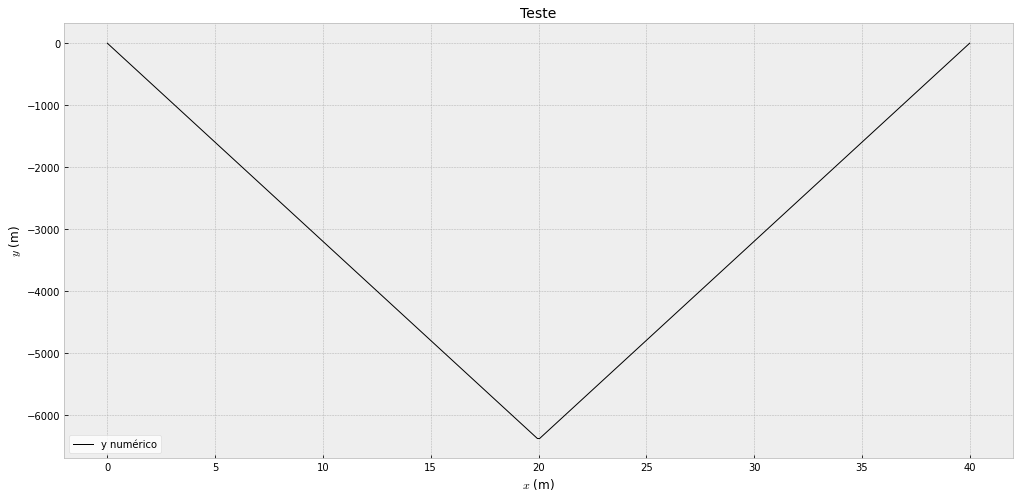

In [25]:
L = 40.0

x_teste = np.linspace(0,L,400)
def f_teste(x):
   return (-0.2956*abs(-1081.13)*x)*np.heaviside(-x+L/2.0, 1.0) + (-0.2956*abs(1081.13)*L + 0.2956*abs(-1081.13)*x)*np.heaviside(x-L/2.0, 0.0)

plt.style.use('bmh')

fig1, ax1 = plt.subplots(sharey=False, sharex=False, figsize = (17,8))

ax1.plot(x_teste,f_teste(x_teste), color='k', linewidth=1.0, label=r'y numérico')
ax1.set_title('Teste',fontdict={'fontsize':14})
ax1.set_xlabel('$x$ (m)',fontdict={'fontsize':12})
ax1.set_ylabel('$y$ (m)',fontdict={'fontsize':12})
ax1.legend(loc='best',facecolor ='w')

Fully restrained force: 1057479.2454615668
Maximum Effectie Axial force: -6391.63978257327


c:\Python3.9.5\lib\site-packages\numpy\linalg\linalg.py:2154: RuntimeWarning: overflow encountered in det
  r = _umath_linalg.det(a, signature=signature)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


inf


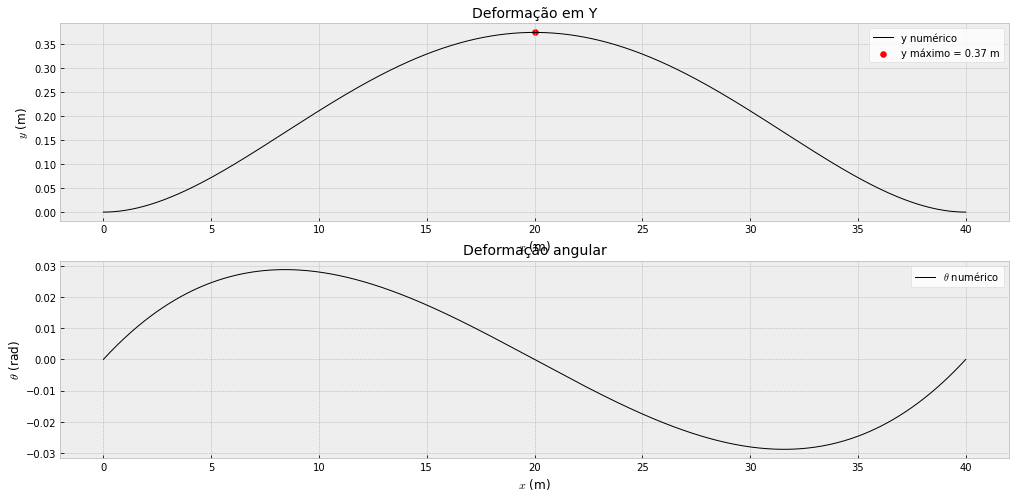

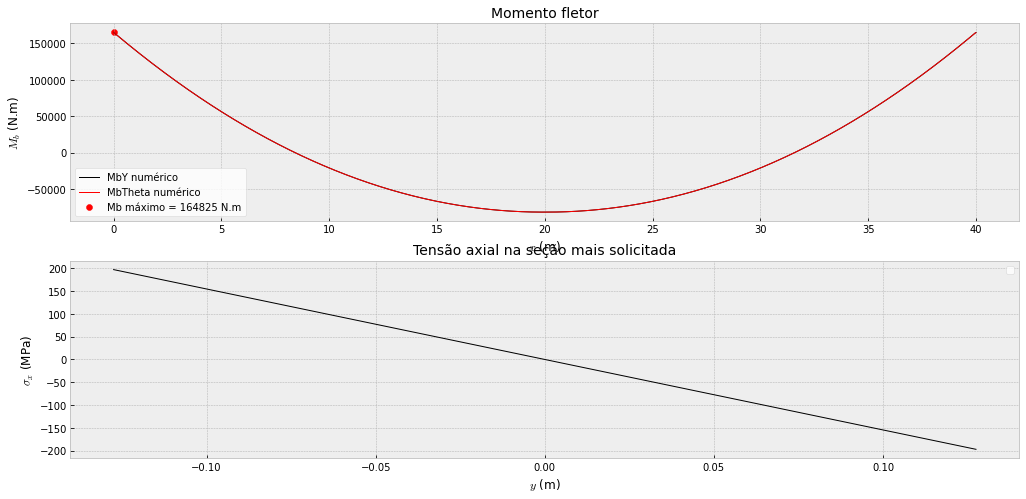

In [15]:
# parametros da simulacao

## malha
L = 40.0   # m
ne = 1000   #n elementos
nx = ne+1   #n nos
nGL = 2*nx

## tubulacao
#d = 0.180  # m
#t = 0.022   # m
#D = d + 2.0*t   # m
#A = np.pi*(D**2.0 - d**2.0)/4.0   # m^2
#I = np.pi*(D**4.0 - d**4.0)/64.0   # m^4
#E = 206.0*10.0**9.0   # GPa
#rho = 7800.0   # kg/m^3
#rho_l = rho*A   # kg/m
## viga de secao retangular
#a = 0.10  # m
#b = 0.20  # m
#A = a*b   # m^2
#I = 0.10*0.20**3/12.0
#E = 206.0*10.0**9.0   # GPa
#rho = 7800.0   # kg/m^3
#rho_l = rho*A   # kg/m
## RC2-U Prod Mero 2, 180 ALO, flooded, Case 19 - RLT UE, PSI UE/UE
OD = 0.255   #m
t = 0.021   #m   
ID = OD - 2.0*t   #m
A = np.pi*(OD**2.0 - ID**2.0)/4.0   #m^2
I = np.pi*(OD**4.0 - ID**4.0)/64.0   #m^4
E = 206.0*10.0**9.0   #Pa
EI = E*I

coat_ID = OD
coat_t = 0.042
coat_OD = coat_ID + 2*coat_t   #m

liner_OD = ID
liner_t = 0.0037
liner_ID = liner_OD - 2*liner_t   #m

steel_density = 7850.0   #kg/m^3
coat_density = 707.2   #kg/m^3
liner_density = 8440.0   #kg/m^3
seawater_density = 1038.0   #kg/m^3
embedmentContentDensity_1 = 1038.0    #kg/m^3

steel_weight = A*steel_density                     # Flowline linear weight [kg/m]
coat_weight = (np.pi*(coat_OD**2.0 - coat_ID**2.0)/4.0)*coat_density             # Coating linear weight [kg/m]
liner_weight = (np.pi*(liner_OD**2.0 - liner_ID**2.0)/4.0)*liner_density         # Liner linear weight [kg/m]
pipe_buoyancy_weight = -np.pi*(coat_OD**2.0/4.0)*seawater_density                # Buoyancy of the pipe [kg/m]

pipe_weight_wo_content = steel_weight + liner_weight + coat_weight + pipe_buoyancy_weight    # Total linear weight [kg/m]
cont_weight_1 = np.pi*((liner_ID**2.0)/4.0)*embedmentContentDensity_1          # Content linear weight used for embedment - Contact #1 [kg/m]

gravity = -9.81 #m/s^2

q = (pipe_weight_wo_content + cont_weight_1)*gravity   #N/m

## lateral friction coefficient
mu_lat_res = 1.15

## axial friction coefficient
mu_ax_res = 0.2956

# cargas
def f_lat(x):
    return mu_lat_res*abs(q)   # N

def f_ax(x):
   return (-mu_ax_res*abs(q)*x)*np.heaviside(-x+L/2.0, 1.0) + (-mu_ax_res*abs(q)*L + mu_ax_res*abs(q)*x)*np.heaviside(x-L/2.0, 0.0)

def df_ax(x):
   return mu_ax_res*abs(q)*(np.heaviside(x-L/2.0, 0.0) - np.heaviside(L/2.0-x, 1.0))

#c = 4*np.pi
#P = -c*E*I/L**2   # N

RLT = 156.96e3   # N
DP = 60*1e6   # Pa
Ai = np.pi*(ID**2.0)/4.0   # m^2
nu = 0.303   # Poisson
As = A   # m^2
alpha = 1.17e-5   # °C^(-1)
DT = 10   # °C
P = abs(RLT - DP*Ai*(1-2*nu) - As*alpha*DT*E)   # Effective Axial Force

print('Fully restrained force: {}'.format(P))

print('Maximum Effectie Axial force: {}'.format(f_ax(L/2.0)))

# geracao de malha 1D
X = np.linspace(0.0,L,nx)
dbX = np.stack((X,X))
dbX = dbX.transpose()
dbX = dbX.flatten()

# CCs
## x
Lyo = 0.0
Lyf = L
Lto = 0.0
Ltf = L

## outputs
Yo = 0.0
Yf = 0.0
Thetao = 0.0
Thetaf = 0.0

IEN_GL = np.zeros( (ne,4),dtype='int' )
for e in range(0,ne):
  IEN_GL[e] = [2*e,2*e+1,2*e+2,2*e+3]

# lista de indices de condicao de contorno
# int() truncates float, so if you have 12.8, using int() you get 12

ccY = [2*int(Lyo*ne/L), 2*int(Lyf*ne/L) + 2]
ccTheta = [2*int(Lto*ne/L) + 1, 2*int(Ltf*ne/L) + 3]

if int(Lyf*ne/L) == ne:
  ccY = [2*int(Lyo*ne/L), 2*(int(Lyf*ne/L) - 1) + 2]

if int(Ltf*ne/L) == ne:
  ccTheta = [2*int(Lto*ne/L) + 1, 2*(int(Ltf*ne/L) - 1) + 3]

# vetor com valores das condicoes de contorno
Ycc = np.empty( (nGL),dtype='float' )

Ycc[ccY[0]] = Yo
Ycc[ccY[1]] = Yf

Thetacc = np.empty( (nGL),dtype='float' )

Thetacc[ccTheta[0]] = Thetao
Thetacc[ccTheta[1]] = Thetaf

# inicializacao das matrizes globais
K = np.zeros( (nGL,nGL),dtype='float' )
dK = np.zeros( (nGL,nGL),dtype='float' )
G = np.zeros( (nGL,nGL),dtype='float' )
#Q = np.zeros( (nGL,nGL),dtype='float' )
Q = np.zeros( (nGL),dtype='float' )

# obtendo matrizes elementares
## funcoes de interpolacao

dK11 = lambda x,X1,X2 : dBh11(x,X1,X2)*dBh11(x,X1,X2)
dK12 = lambda x,X1,X2 : dBh11(x,X1,X2)*dBh12(x,X1,X2)
dK13 = lambda x,X1,X2:  dBh11(x,X1,X2)*dBh13(x,X1,X2)
dK14 = lambda x,X1,X2 : dBh11(x,X1,X2)*dBh14(x,X1,X2)
dK21 = lambda x,X1,X2 : dBh12(x,X1,X2)*dBh11(x,X1,X2)
dK22 = lambda x,X1,X2 : dBh12(x,X1,X2)*dBh12(x,X1,X2)
dK23 = lambda x,X1,X2 : dBh12(x,X1,X2)*dBh13(x,X1,X2)
dK24 = lambda x,X1,X2 : dBh12(x,X1,X2)*dBh14(x,X1,X2)
dK31 = lambda x,X1,X2 : dBh13(x,X1,X2)*dBh11(x,X1,X2)
dK32 = lambda x,X1,X2 : dBh13(x,X1,X2)*dBh12(x,X1,X2)
dK33 = lambda x,X1,X2 : dBh13(x,X1,X2)*dBh13(x,X1,X2)
dK34 = lambda x,X1,X2 : dBh13(x,X1,X2)*dBh14(x,X1,X2)
dK41 = lambda x,X1,X2 : dBh14(x,X1,X2)*dBh11(x,X1,X2)
dK42 = lambda x,X1,X2 : dBh14(x,X1,X2)*dBh12(x,X1,X2)
dK43 = lambda x,X1,X2 : dBh14(x,X1,X2)*dBh13(x,X1,X2)
dK44 = lambda x,X1,X2 : dBh14(x,X1,X2)*dBh14(x,X1,X2)

K11 = lambda x,X1,X2 : f_ax(x)*Bh11(x,X1,X2)*Bh11(x,X1,X2)
K12 = lambda x,X1,X2 : f_ax(x)*Bh11(x,X1,X2)*Bh12(x,X1,X2)
K13 = lambda x,X1,X2 : f_ax(x)*Bh11(x,X1,X2)*Bh13(x,X1,X2)
K14 = lambda x,X1,X2 : f_ax(x)*Bh11(x,X1,X2)*Bh14(x,X1,X2)
K21 = lambda x,X1,X2 : f_ax(x)*Bh12(x,X1,X2)*Bh11(x,X1,X2)
K22 = lambda x,X1,X2 : f_ax(x)*Bh12(x,X1,X2)*Bh12(x,X1,X2)
K23 = lambda x,X1,X2 : f_ax(x)*Bh12(x,X1,X2)*Bh13(x,X1,X2)
K24 = lambda x,X1,X2 : f_ax(x)*Bh12(x,X1,X2)*Bh14(x,X1,X2)
K31 = lambda x,X1,X2 : f_ax(x)*Bh13(x,X1,X2)*Bh11(x,X1,X2)
K32 = lambda x,X1,X2 : f_ax(x)*Bh13(x,X1,X2)*Bh12(x,X1,X2)
K33 = lambda x,X1,X2 : f_ax(x)*Bh13(x,X1,X2)*Bh13(x,X1,X2)
K34 = lambda x,X1,X2 : f_ax(x)*Bh13(x,X1,X2)*Bh14(x,X1,X2)
K41 = lambda x,X1,X2 : f_ax(x)*Bh14(x,X1,X2)*Bh11(x,X1,X2)
K42 = lambda x,X1,X2 : f_ax(x)*Bh14(x,X1,X2)*Bh12(x,X1,X2)
K43 = lambda x,X1,X2 : f_ax(x)*Bh14(x,X1,X2)*Bh13(x,X1,X2)
K44 = lambda x,X1,X2 : f_ax(x)*Bh14(x,X1,X2)*Bh14(x,X1,X2)

G11 = lambda x,X1,X2 : df_ax(x)*Bh11(x,X1,X2)*Nh11(x,X1,X2)
G12 = lambda x,X1,X2 : df_ax(x)*Bh11(x,X1,X2)*Nh12(x,X1,X2)
G13 = lambda x,X1,X2:  df_ax(x)*Bh11(x,X1,X2)*Nh13(x,X1,X2)
G14 = lambda x,X1,X2 : df_ax(x)*Bh11(x,X1,X2)*Nh14(x,X1,X2)
G21 = lambda x,X1,X2 : df_ax(x)*Bh12(x,X1,X2)*Nh11(x,X1,X2)
G22 = lambda x,X1,X2 : df_ax(x)*Bh12(x,X1,X2)*Nh12(x,X1,X2)
G23 = lambda x,X1,X2 : df_ax(x)*Bh12(x,X1,X2)*Nh13(x,X1,X2)
G24 = lambda x,X1,X2 : df_ax(x)*Bh12(x,X1,X2)*Nh14(x,X1,X2)
G31 = lambda x,X1,X2 : df_ax(x)*Bh13(x,X1,X2)*Nh11(x,X1,X2)
G32 = lambda x,X1,X2 : df_ax(x)*Bh13(x,X1,X2)*Nh12(x,X1,X2)
G33 = lambda x,X1,X2 : df_ax(x)*Bh13(x,X1,X2)*Nh13(x,X1,X2)
G34 = lambda x,X1,X2 : df_ax(x)*Bh13(x,X1,X2)*Nh14(x,X1,X2)
G41 = lambda x,X1,X2 : df_ax(x)*Bh14(x,X1,X2)*Nh11(x,X1,X2)
G42 = lambda x,X1,X2 : df_ax(x)*Bh14(x,X1,X2)*Nh12(x,X1,X2)
G43 = lambda x,X1,X2 : df_ax(x)*Bh14(x,X1,X2)*Nh13(x,X1,X2)
G44 = lambda x,X1,X2 : df_ax(x)*Bh14(x,X1,X2)*Nh14(x,X1,X2)

Q11 = lambda x,X1,X2 : f_lat(x)*Nh11(x,X1,X2)
Q12 = lambda x,X1,X2 : f_lat(x)*Nh12(x,X1,X2)
Q13 = lambda x,X1,X2 : f_lat(x)*Nh13(x,X1,X2)
Q14 = lambda x,X1,X2 : f_lat(x)*Nh14(x,X1,X2)

## Funcao de integracao a ser usada
def INTEGRACAO_1(f,e):
     v1,v2,v3,v4 = IEN_GL[e]
     return sp.integrate.quad(f,dbX[v1],dbX[v3],(dbX[v1],dbX[v3]))[0]

## Integrando
dkelem = np.empty((4,4,ne))
kelem = np.empty((4,4,ne))
gelem = np.empty((4,4,ne))
#qelem = np.empty((4,4,ne))
qelem = np.empty((4,ne))

for e in range(0,ne):
    dKe = E*I*np.array([[INTEGRACAO_1(dK11,e),INTEGRACAO_1(dK12,e),INTEGRACAO_1(dK13,e),INTEGRACAO_1(dK14,e)],
                        [INTEGRACAO_1(dK21,e),INTEGRACAO_1(dK22,e),INTEGRACAO_1(dK23,e),INTEGRACAO_1(dK24,e)],
                        [INTEGRACAO_1(dK31,e),INTEGRACAO_1(dK32,e),INTEGRACAO_1(dK33,e),INTEGRACAO_1(dK34,e)],
                        [INTEGRACAO_1(dK41,e),INTEGRACAO_1(dK42,e),INTEGRACAO_1(dK43,e),INTEGRACAO_1(dK44,e)]])
    
    Ke = np.array([[INTEGRACAO_1(K11,e),INTEGRACAO_1(K12,e),INTEGRACAO_1(K13,e),INTEGRACAO_1(K14,e)],
                   [INTEGRACAO_1(K21,e),INTEGRACAO_1(K22,e),INTEGRACAO_1(K23,e),INTEGRACAO_1(K24,e)],
                   [INTEGRACAO_1(K31,e),INTEGRACAO_1(K32,e),INTEGRACAO_1(K33,e),INTEGRACAO_1(K34,e)],
                   [INTEGRACAO_1(K41,e),INTEGRACAO_1(K42,e),INTEGRACAO_1(K43,e),INTEGRACAO_1(K44,e)]])     

    Ge = np.array([[INTEGRACAO_1(G11,e),INTEGRACAO_1(G12,e),INTEGRACAO_1(G13,e),INTEGRACAO_1(G14,e)],
                   [INTEGRACAO_1(G21,e),INTEGRACAO_1(G22,e),INTEGRACAO_1(G23,e),INTEGRACAO_1(G24,e)],
                   [INTEGRACAO_1(G31,e),INTEGRACAO_1(G32,e),INTEGRACAO_1(G33,e),INTEGRACAO_1(G34,e)],
                   [INTEGRACAO_1(G41,e),INTEGRACAO_1(G42,e),INTEGRACAO_1(G43,e),INTEGRACAO_1(G44,e)]])

    #Qe = np.array([[INTEGRACAO_1(Q11,e),INTEGRACAO_1(Q12,e),INTEGRACAO_1(Q13,e),INTEGRACAO_1(Q14,e)],
                   #[INTEGRACAO_1(Q21,e),INTEGRACAO_1(Q22,e),INTEGRACAO_1(Q23,e),INTEGRACAO_1(Q24,e)],
                   #[INTEGRACAO_1(Q31,e),INTEGRACAO_1(Q32,e),INTEGRACAO_1(Q33,e),INTEGRACAO_1(Q34,e)],
                   #[INTEGRACAO_1(Q41,e),INTEGRACAO_1(Q42,e),INTEGRACAO_1(Q43,e),INTEGRACAO_1(Q44,e)]]) 

    Qe = np.array([INTEGRACAO_1(Q11,e),INTEGRACAO_1(Q12,e),INTEGRACAO_1(Q13,e),INTEGRACAO_1(Q14,e)])
    
    dkelem[:,:,e] = dKe
    kelem[:,:,e] = Ke
    gelem[:,:,e] = Ge
    #qelem[:,:,e] = Qe
    qelem[:,e] = Qe

for e in range(0,ne):

 for ilocal in range(0,4):
  iglobal = IEN_GL[e,ilocal]
  for jlocal in range(0,4):
   jglobal = IEN_GL[e,jlocal]

   dK[iglobal,jglobal] += dkelem[ilocal,jlocal,e]
   K[iglobal,jglobal] += kelem[ilocal,jlocal,e]
   G[iglobal,jglobal] += gelem[ilocal,jlocal,e]
   #Q[iglobal,jglobal] += qelem[ilocal,jlocal,e]

for e in range(0,ne):
 for ilocal in range(0,4):
  Q[2*e + ilocal] += qelem[ilocal,e]

#print(np.array_str(K, precision=2, suppress_small=True))
#print(np.array_str(Q, precision=2, suppress_small=True))

# definicao do sistema linear
A = (dK - G - K)
#B = Q@q(dbX)
B = Q

# imposicao das c.c.s de Dirichlet em A e b
for i in ccY:
  A[i,:] = 0.0   # zerar linha
  A[i,i] = 1.0   # incluir 1 na diagonal

  B[i] = Ycc[i]

for i in ccTheta:
  A[i,:] = 0.0   # zerar linha
  A[i,i] = 1.0   # incluir 1 na diagonal

  B[i] = Thetacc[i]

print(np.linalg.det(A))


# solucao
cscA = sp.sparse.csc_matrix(A)   # Matrix form that improves sparse.linalg.solve
SOL = sp.sparse.linalg.spsolve(cscA,B)
#SOL = np.linalg.solve(A,B)
SOL = SOL.reshape((int(nGL/2),2))

Y = SOL[:,0]
Theta = SOL[:,1]

index_Ymax = np.where(abs(Y) == np.max(abs(Y)))   # for plotting max Y
index_Ymax = index_Ymax[0][0]

# curvatura (por diferenças centradas de ordem 2)
d2Y = np.empty(len(Y))

ho = (X[1] - X[0])
d2Y[0] = (2*Y[1] - 2*Y[0])/ho**2

hf = (X[-1] - X[-2])
d2Y[-1] = (- 2*Y[-1] + 2*Y[-2])/hf**2

for i in range(1,len(Y)-1):
    h = (X[i] - X[i-1])
    d2Y[i] = (Y[i+1] - 2*Y[i] + Y[i-1])/h**2

# curvatura via theta (dtheta/dx) (por diferenças centradas de ordem 1 e diferenças atrasadas ou avançadas nos contornos)

dTheta = np.empty(len(Theta))

ho = (X[1] - X[0])
dTheta[0] = (Theta[1] - Theta[0])/ho

hf = (X[-1] - X[-2])
dTheta[-1] = (Theta[-1] - Theta[-2])/hf

for i in range(1,len(Theta)-1):
    h = (X[i] - X[i-1])
    dTheta[i] = (Theta[i+1] - Theta[i-1])/(2*h)

# momento fletor e momento fletor maximo
MbY = E*I*d2Y# em MPa

index_MbYmax = np.where(abs(MbY) == np.max(abs(MbY)))   # for plotting max MbY
index_MbYmax = index_MbYmax[0][0]
MbYmax = MbY[index_MbYmax]

MbTheta = E*I*dTheta   # N.m
MbThetamax = np.max(abs(MbTheta))  # N.m

index_MbThetamax = np.where(abs(MbTheta) == np.max(abs(MbTheta)))   # for plotting max MbTheta
index_MbThetamax = index_MbThetamax[0][0]
MbThetamax = MbTheta[index_MbThetamax]

# tensão axial na secao mais solicitada
Y_CrossSection = np.linspace(-OD/2.0, OD/2.0, nx)
#Y_CrossSection = np.linspace(-b/2.0, b/2.0, nx)

sigmab = (- MbYmax*Y_CrossSection/I)*10.0**(-6.0)   # MPa

# plotando ################################
plt.style.use('bmh')

fig1, ((ax1), (ax2)) = plt.subplots(2, sharey=False, sharex=False, figsize = (17,8))

ax1.plot(X,Y, color='k', linewidth=1.0, label=r'y numérico')
ax1.scatter(X[index_Ymax], Y[index_Ymax], color='red', label=r'y máximo = {} m'.format(np.around(max(Y), 2)))
ax1.set_title('Deformação em Y',fontdict={'fontsize':14})
ax1.set_xlabel('$x$ (m)',fontdict={'fontsize':12})
ax1.set_ylabel('$y$ (m)',fontdict={'fontsize':12})
ax1.legend(loc='best',facecolor ='w')

ax2.plot(X,Theta, color='k', linewidth=1.0, label=r'$\theta$ numérico')
ax2.set_title('Deformação angular',fontdict={'fontsize':14})
ax2.set_xlabel('$x$ (m)',fontdict={'fontsize':12})
ax2.set_ylabel('$\\theta$ (rad)',fontdict={'fontsize':12})
ax2.legend(loc='best',facecolor ='w')


fig1, ((ax3), (ax4)) = plt.subplots(2, sharey=False, sharex=False, figsize = (17,8))

ax3.plot(X,MbY, color='k', linewidth=1.0, label=r'MbY numérico')
ax3.plot(X,MbTheta, 'r', linewidth=1.0, label=r'MbTheta numérico')
ax3.scatter(X[index_MbYmax], MbYmax, color='red', label=r'Mb máximo = {} N.m'.format(int(MbYmax)))
ax3.set_title('Momento fletor',fontdict={'fontsize':14})
ax3.set_xlabel('$x$ (m)',fontdict={'fontsize':12})
ax3.set_ylabel('$M_b$ (N.m)',fontdict={'fontsize':12})
ax3.legend(loc='best',facecolor ='w')

ax4.plot(Y_CrossSection,sigmab, color='k', linewidth=1.0)
ax4.set_title('Tensão axial na seção mais solicitada',fontdict={'fontsize':14})
ax4.set_xlabel('$y$ (m)',fontdict={'fontsize':12})
ax4.set_ylabel('$\\sigma_x$ (MPa)',fontdict={'fontsize':12})
ax4.legend(loc='best',facecolor ='w')

plt.show()